In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2218485, 828)
(2218485, 1)
validation
(242003, 828)
(242003, 1)
test
(221567, 828)
(221567, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/222 [..............................] - ETA: 5:21 - loss: 0.1034 - STD: 1.4911e-04 - MAE: 0.2764

  4/222 [..............................] - ETA: 4s - loss: 0.0848 - STD: 4.6019e-04 - MAE: 0.2415  

  7/222 [..............................] - ETA: 4s - loss: 0.0784 - STD: 7.8819e-04 - MAE: 0.2352

 10/222 [>.............................] - ETA: 4s - loss: 0.0763 - STD: 0.0011 - MAE: 0.2353    

 13/222 [>.............................] - ETA: 4s - loss: 0.0741 - STD: 0.0014 - MAE: 0.2330

 16/222 [=>............................] - ETA: 4s - loss: 0.0731 - STD: 0.0017 - MAE: 0.2311

 19/222 [=>............................] - ETA: 4s - loss: 0.0722 - STD: 0.0020 - MAE: 0.2299

 22/222 [=>............................] - ETA: 4s - loss: 0.0714 - STD: 0.0024 - MAE: 0.2295

 25/222 [==>...........................] - ETA: 4s - loss: 0.0708 - STD: 0.0029 - MAE: 0.2292

 28/222 [==>...........................] - ETA: 4s - loss: 0.0702 - STD: 0.0034 - MAE: 0.2283

 31/222 [===>..........................] - ETA: 4s - loss: 0.0696 - STD: 0.0041 - MAE: 0.2274

 34/222 [===>..........................] - ETA: 4s - loss: 0.0691 - STD: 0.0051 - MAE: 0.2267

 37/222 [====>.........................] - ETA: 4s - loss: 0.0685 - STD: 0.0065 - MAE: 0.2261

 40/222 [====>.........................] - ETA: 4s - loss: 0.0678 - STD: 0.0082 - MAE: 0.2251

 43/222 [====>.........................] - ETA: 4s - loss: 0.0672 - STD: 0.0106 - MAE: 0.2239

 46/222 [=====>........................] - ETA: 3s - loss: 0.0664 - STD: 0.0138 - MAE: 0.2227

 49/222 [=====>........................] - ETA: 3s - loss: 0.0655 - STD: 0.0178 - MAE: 0.2212

 52/222 [======>.......................] - ETA: 3s - loss: 0.0647 - STD: 0.0223 - MAE: 0.2193

 55/222 [======>.......................] - ETA: 3s - loss: 0.0639 - STD: 0.0274 - MAE: 0.2176

 58/222 [======>.......................] - ETA: 3s - loss: 0.0631 - STD: 0.0324 - MAE: 0.2159

 61/222 [=======>......................] - ETA: 3s - loss: 0.0623 - STD: 0.0371 - MAE: 0.2141

 64/222 [=======>......................] - ETA: 3s - loss: 0.0616 - STD: 0.0413 - MAE: 0.2125

 67/222 [========>.....................] - ETA: 3s - loss: 0.0610 - STD: 0.0452 - MAE: 0.2110

 70/222 [========>.....................] - ETA: 3s - loss: 0.0604 - STD: 0.0488 - MAE: 0.2097

 73/222 [========>.....................] - ETA: 3s - loss: 0.0598 - STD: 0.0525 - MAE: 0.2083

 76/222 [=========>....................] - ETA: 3s - loss: 0.0593 - STD: 0.0561 - MAE: 0.2071

 79/222 [=========>....................] - ETA: 3s - loss: 0.0588 - STD: 0.0596 - MAE: 0.2058

 82/222 [==========>...................] - ETA: 3s - loss: 0.0583 - STD: 0.0629 - MAE: 0.2047

 85/222 [==========>...................] - ETA: 3s - loss: 0.0578 - STD: 0.0658 - MAE: 0.2036

 88/222 [==========>...................] - ETA: 3s - loss: 0.0573 - STD: 0.0685 - MAE: 0.2026

 91/222 [===========>..................] - ETA: 2s - loss: 0.0569 - STD: 0.0711 - MAE: 0.2016

 94/222 [===========>..................] - ETA: 2s - loss: 0.0565 - STD: 0.0736 - MAE: 0.2006

 97/222 [============>.................] - ETA: 2s - loss: 0.0561 - STD: 0.0760 - MAE: 0.1998

100/222 [============>.................] - ETA: 2s - loss: 0.0556 - STD: 0.0783 - MAE: 0.1988

103/222 [============>.................] - ETA: 2s - loss: 0.0552 - STD: 0.0804 - MAE: 0.1978

106/222 [=============>................] - ETA: 2s - loss: 0.0548 - STD: 0.0825 - MAE: 0.1969

109/222 [=============>................] - ETA: 2s - loss: 0.0543 - STD: 0.0844 - MAE: 0.1958

112/222 [==============>...............] - ETA: 2s - loss: 0.0538 - STD: 0.0863 - MAE: 0.1947

115/222 [==============>...............] - ETA: 2s - loss: 0.0533 - STD: 0.0880 - MAE: 0.1937

118/222 [==============>...............] - ETA: 2s - loss: 0.0528 - STD: 0.0900 - MAE: 0.1925

121/222 [===============>..............] - ETA: 2s - loss: 0.0523 - STD: 0.0920 - MAE: 0.1913

124/222 [===============>..............] - ETA: 2s - loss: 0.0518 - STD: 0.0942 - MAE: 0.1901

127/222 [================>.............] - ETA: 2s - loss: 0.0513 - STD: 0.0963 - MAE: 0.1889

130/222 [================>.............] - ETA: 2s - loss: 0.0508 - STD: 0.0984 - MAE: 0.1877

133/222 [================>.............] - ETA: 2s - loss: 0.0503 - STD: 0.1004 - MAE: 0.1865

136/222 [=================>............] - ETA: 1s - loss: 0.0498 - STD: 0.1024 - MAE: 0.1853

139/222 [=================>............] - ETA: 1s - loss: 0.0493 - STD: 0.1043 - MAE: 0.1841

142/222 [==================>...........] - ETA: 1s - loss: 0.0488 - STD: 0.1063 - MAE: 0.1829

145/222 [==================>...........] - ETA: 1s - loss: 0.0484 - STD: 0.1082 - MAE: 0.1817

148/222 [===================>..........] - ETA: 1s - loss: 0.0479 - STD: 0.1100 - MAE: 0.1806

151/222 [===================>..........] - ETA: 1s - loss: 0.0475 - STD: 0.1118 - MAE: 0.1795

154/222 [===================>..........] - ETA: 1s - loss: 0.0470 - STD: 0.1134 - MAE: 0.1784

157/222 [====================>.........] - ETA: 1s - loss: 0.0466 - STD: 0.1151 - MAE: 0.1773

160/222 [====================>.........] - ETA: 1s - loss: 0.0462 - STD: 0.1166 - MAE: 0.1762

163/222 [=====================>........] - ETA: 1s - loss: 0.0458 - STD: 0.1182 - MAE: 0.1752

166/222 [=====================>........] - ETA: 1s - loss: 0.0454 - STD: 0.1198 - MAE: 0.1741

169/222 [=====================>........] - ETA: 1s - loss: 0.0450 - STD: 0.1213 - MAE: 0.1731

172/222 [======================>.......] - ETA: 1s - loss: 0.0446 - STD: 0.1227 - MAE: 0.1721

175/222 [======================>.......] - ETA: 1s - loss: 0.0442 - STD: 0.1242 - MAE: 0.1712

178/222 [=======================>......] - ETA: 0s - loss: 0.0439 - STD: 0.1256 - MAE: 0.1702

179/222 [=======================>......] - ETA: 1s - loss: 0.0438 - STD: 0.1260 - MAE: 0.1699

182/222 [=======================>......] - ETA: 1s - loss: 0.0434 - STD: 0.1273 - MAE: 0.1690

185/222 [========================>.....] - ETA: 1s - loss: 0.0431 - STD: 0.1287 - MAE: 0.1681

188/222 [========================>.....] - ETA: 0s - loss: 0.0427 - STD: 0.1299 - MAE: 0.1672

191/222 [========================>.....] - ETA: 0s - loss: 0.0424 - STD: 0.1311 - MAE: 0.1664

194/222 [=========================>....] - ETA: 0s - loss: 0.0421 - STD: 0.1324 - MAE: 0.1656

197/222 [=========================>....] - ETA: 0s - loss: 0.0418 - STD: 0.1335 - MAE: 0.1648

200/222 [==========================>...] - ETA: 0s - loss: 0.0414 - STD: 0.1347 - MAE: 0.1640

203/222 [==========================>...] - ETA: 0s - loss: 0.0411 - STD: 0.1358 - MAE: 0.1632

206/222 [==========================>...] - ETA: 0s - loss: 0.0408 - STD: 0.1369 - MAE: 0.1624

209/222 [===========================>..] - ETA: 0s - loss: 0.0405 - STD: 0.1379 - MAE: 0.1617

212/222 [===========================>..] - ETA: 0s - loss: 0.0403 - STD: 0.1390 - MAE: 0.1609

215/222 [============================>.] - ETA: 0s - loss: 0.0400 - STD: 0.1401 - MAE: 0.1602

218/222 [============================>.] - ETA: 0s - loss: 0.0398 - STD: 0.1409 - MAE: 0.1598

221/222 [============================>.] - ETA: 0s - loss: 0.0396 - STD: 0.1418 - MAE: 0.1592

222/222 [==============================] - 8s 31ms/step - loss: 0.0395 - STD: 0.1421 - MAE: 0.1590 - val_loss: 0.0200 - val_STD: 0.1160 - val_MAE: 0.1035


Epoch 2/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0207 - STD: 0.2168 - MAE: 0.1100

  4/222 [..............................] - ETA: 4s - loss: 0.0218 - STD: 0.2075 - MAE: 0.1138 

  7/222 [..............................] - ETA: 4s - loss: 0.0216 - STD: 0.2054 - MAE: 0.1137

 10/222 [>.............................] - ETA: 4s - loss: 0.0214 - STD: 0.2049 - MAE: 0.1133

 13/222 [>.............................] - ETA: 4s - loss: 0.0212 - STD: 0.2051 - MAE: 0.1128

 16/222 [=>............................] - ETA: 4s - loss: 0.0210 - STD: 0.2057 - MAE: 0.1122

 19/222 [=>............................] - ETA: 4s - loss: 0.0209 - STD: 0.2063 - MAE: 0.1117

 22/222 [=>............................] - ETA: 4s - loss: 0.0207 - STD: 0.2073 - MAE: 0.1111

 25/222 [==>...........................] - ETA: 4s - loss: 0.0206 - STD: 0.2082 - MAE: 0.1106

 28/222 [==>...........................] - ETA: 4s - loss: 0.0205 - STD: 0.2089 - MAE: 0.1102

 31/222 [===>..........................] - ETA: 4s - loss: 0.0204 - STD: 0.2094 - MAE: 0.1100

 34/222 [===>..........................] - ETA: 4s - loss: 0.0203 - STD: 0.2099 - MAE: 0.1097

 37/222 [====>.........................] - ETA: 4s - loss: 0.0202 - STD: 0.2102 - MAE: 0.1093

 40/222 [====>.........................] - ETA: 4s - loss: 0.0200 - STD: 0.2106 - MAE: 0.1090

 43/222 [====>.........................] - ETA: 4s - loss: 0.0199 - STD: 0.2110 - MAE: 0.1086

 46/222 [=====>........................] - ETA: 3s - loss: 0.0198 - STD: 0.2113 - MAE: 0.1083

 49/222 [=====>........................] - ETA: 3s - loss: 0.0197 - STD: 0.2116 - MAE: 0.1080

 52/222 [======>.......................] - ETA: 3s - loss: 0.0196 - STD: 0.2119 - MAE: 0.1078

 55/222 [======>.......................] - ETA: 3s - loss: 0.0196 - STD: 0.2122 - MAE: 0.1075

 58/222 [======>.......................] - ETA: 3s - loss: 0.0195 - STD: 0.2126 - MAE: 0.1072

 61/222 [=======>......................] - ETA: 3s - loss: 0.0194 - STD: 0.2129 - MAE: 0.1070

 64/222 [=======>......................] - ETA: 3s - loss: 0.0193 - STD: 0.2131 - MAE: 0.1068

 67/222 [========>.....................] - ETA: 3s - loss: 0.0193 - STD: 0.2134 - MAE: 0.1066

 70/222 [========>.....................] - ETA: 3s - loss: 0.0192 - STD: 0.2134 - MAE: 0.1065

 73/222 [========>.....................] - ETA: 3s - loss: 0.0192 - STD: 0.2136 - MAE: 0.1064

 76/222 [=========>....................] - ETA: 3s - loss: 0.0191 - STD: 0.2138 - MAE: 0.1062

 79/222 [=========>....................] - ETA: 3s - loss: 0.0191 - STD: 0.2140 - MAE: 0.1060

 82/222 [==========>...................] - ETA: 3s - loss: 0.0190 - STD: 0.2142 - MAE: 0.1058

 85/222 [==========>...................] - ETA: 3s - loss: 0.0190 - STD: 0.2142 - MAE: 0.1058

 88/222 [==========>...................] - ETA: 3s - loss: 0.0190 - STD: 0.2144 - MAE: 0.1057

 91/222 [===========>..................] - ETA: 2s - loss: 0.0190 - STD: 0.2145 - MAE: 0.1057

 94/222 [===========>..................] - ETA: 2s - loss: 0.0189 - STD: 0.2146 - MAE: 0.1056

 97/222 [============>.................] - ETA: 2s - loss: 0.0189 - STD: 0.2147 - MAE: 0.1055

100/222 [============>.................] - ETA: 2s - loss: 0.0188 - STD: 0.2147 - MAE: 0.1053

103/222 [============>.................] - ETA: 2s - loss: 0.0188 - STD: 0.2148 - MAE: 0.1051

106/222 [=============>................] - ETA: 2s - loss: 0.0187 - STD: 0.2150 - MAE: 0.1050

109/222 [=============>................] - ETA: 2s - loss: 0.0187 - STD: 0.2151 - MAE: 0.1049

112/222 [==============>...............] - ETA: 2s - loss: 0.0186 - STD: 0.2152 - MAE: 0.1047

115/222 [==============>...............] - ETA: 2s - loss: 0.0186 - STD: 0.2154 - MAE: 0.1046

118/222 [==============>...............] - ETA: 2s - loss: 0.0185 - STD: 0.2156 - MAE: 0.1044

121/222 [===============>..............] - ETA: 2s - loss: 0.0185 - STD: 0.2157 - MAE: 0.1043

124/222 [===============>..............] - ETA: 2s - loss: 0.0184 - STD: 0.2158 - MAE: 0.1041

127/222 [================>.............] - ETA: 2s - loss: 0.0184 - STD: 0.2158 - MAE: 0.1041

130/222 [================>.............] - ETA: 2s - loss: 0.0186 - STD: 0.2160 - MAE: 0.1045

133/222 [================>.............] - ETA: 2s - loss: 0.0186 - STD: 0.2160 - MAE: 0.1045

136/222 [=================>............] - ETA: 1s - loss: 0.0186 - STD: 0.2158 - MAE: 0.1046

139/222 [=================>............] - ETA: 1s - loss: 0.0186 - STD: 0.2157 - MAE: 0.1046

142/222 [==================>...........] - ETA: 1s - loss: 0.0186 - STD: 0.2155 - MAE: 0.1046

145/222 [==================>...........] - ETA: 1s - loss: 0.0186 - STD: 0.2154 - MAE: 0.1045

148/222 [===================>..........] - ETA: 1s - loss: 0.0185 - STD: 0.2154 - MAE: 0.1044

151/222 [===================>..........] - ETA: 1s - loss: 0.0185 - STD: 0.2155 - MAE: 0.1043

154/222 [===================>..........] - ETA: 1s - loss: 0.0185 - STD: 0.2156 - MAE: 0.1042

157/222 [====================>.........] - ETA: 1s - loss: 0.0184 - STD: 0.2157 - MAE: 0.1041

160/222 [====================>.........] - ETA: 1s - loss: 0.0184 - STD: 0.2159 - MAE: 0.1040

163/222 [=====================>........] - ETA: 1s - loss: 0.0184 - STD: 0.2160 - MAE: 0.1038

166/222 [=====================>........] - ETA: 1s - loss: 0.0183 - STD: 0.2161 - MAE: 0.1037

169/222 [=====================>........] - ETA: 1s - loss: 0.0183 - STD: 0.2162 - MAE: 0.1036

172/222 [======================>.......] - ETA: 1s - loss: 0.0183 - STD: 0.2163 - MAE: 0.1035

175/222 [======================>.......] - ETA: 1s - loss: 0.0182 - STD: 0.2164 - MAE: 0.1034

178/222 [=======================>......] - ETA: 0s - loss: 0.0182 - STD: 0.2165 - MAE: 0.1033

181/222 [=======================>......] - ETA: 0s - loss: 0.0181 - STD: 0.2166 - MAE: 0.1032

184/222 [=======================>......] - ETA: 0s - loss: 0.0181 - STD: 0.2167 - MAE: 0.1031

187/222 [========================>.....] - ETA: 0s - loss: 0.0181 - STD: 0.2167 - MAE: 0.1030

190/222 [========================>.....] - ETA: 0s - loss: 0.0180 - STD: 0.2168 - MAE: 0.1029

193/222 [=========================>....] - ETA: 0s - loss: 0.0180 - STD: 0.2169 - MAE: 0.1027

196/222 [=========================>....] - ETA: 0s - loss: 0.0180 - STD: 0.2170 - MAE: 0.1027

199/222 [=========================>....] - ETA: 0s - loss: 0.0179 - STD: 0.2171 - MAE: 0.1025

202/222 [==========================>...] - ETA: 0s - loss: 0.0179 - STD: 0.2172 - MAE: 0.1024

205/222 [==========================>...] - ETA: 0s - loss: 0.0179 - STD: 0.2173 - MAE: 0.1023

208/222 [===========================>..] - ETA: 0s - loss: 0.0178 - STD: 0.2174 - MAE: 0.1022

211/222 [===========================>..] - ETA: 0s - loss: 0.0178 - STD: 0.2174 - MAE: 0.1021

214/222 [===========================>..] - ETA: 0s - loss: 0.0178 - STD: 0.2175 - MAE: 0.1020

217/222 [============================>.] - ETA: 0s - loss: 0.0177 - STD: 0.2176 - MAE: 0.1019

220/222 [============================>.] - ETA: 0s - loss: 0.0177 - STD: 0.2177 - MAE: 0.1018

222/222 [==============================] - 5s 24ms/step - loss: 0.0177 - STD: 0.2177 - MAE: 0.1018 - val_loss: 0.0248 - val_STD: 0.1267 - val_MAE: 0.1122


Epoch 3/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0215 - STD: 0.2478 - MAE: 0.1075

  4/222 [..............................] - ETA: 4s - loss: 0.0211 - STD: 0.2204 - MAE: 0.1103 

  7/222 [..............................] - ETA: 4s - loss: 0.0192 - STD: 0.2185 - MAE: 0.1056

 10/222 [>.............................] - ETA: 4s - loss: 0.0182 - STD: 0.2183 - MAE: 0.1029

 13/222 [>.............................] - ETA: 4s - loss: 0.0177 - STD: 0.2182 - MAE: 0.1017

 16/222 [=>............................] - ETA: 4s - loss: 0.0173 - STD: 0.2183 - MAE: 0.1005

 19/222 [=>............................] - ETA: 4s - loss: 0.0170 - STD: 0.2187 - MAE: 0.0997

 22/222 [=>............................] - ETA: 4s - loss: 0.0169 - STD: 0.2188 - MAE: 0.0994

 25/222 [==>...........................] - ETA: 4s - loss: 0.0168 - STD: 0.2194 - MAE: 0.0988

 28/222 [==>...........................] - ETA: 4s - loss: 0.0166 - STD: 0.2203 - MAE: 0.0982

 31/222 [===>..........................] - ETA: 4s - loss: 0.0165 - STD: 0.2209 - MAE: 0.0978

 34/222 [===>..........................] - ETA: 4s - loss: 0.0163 - STD: 0.2212 - MAE: 0.0973

 37/222 [====>.........................] - ETA: 4s - loss: 0.0162 - STD: 0.2213 - MAE: 0.0970

 40/222 [====>.........................] - ETA: 4s - loss: 0.0162 - STD: 0.2218 - MAE: 0.0971

 43/222 [====>.........................] - ETA: 4s - loss: 0.0162 - STD: 0.2218 - MAE: 0.0969

 46/222 [=====>........................] - ETA: 3s - loss: 0.0162 - STD: 0.2216 - MAE: 0.0970

 49/222 [=====>........................] - ETA: 3s - loss: 0.0161 - STD: 0.2219 - MAE: 0.0968

 52/222 [======>.......................] - ETA: 3s - loss: 0.0161 - STD: 0.2221 - MAE: 0.0967

 55/222 [======>.......................] - ETA: 3s - loss: 0.0160 - STD: 0.2221 - MAE: 0.0966

 58/222 [======>.......................] - ETA: 3s - loss: 0.0160 - STD: 0.2220 - MAE: 0.0965

 61/222 [=======>......................] - ETA: 3s - loss: 0.0160 - STD: 0.2221 - MAE: 0.0964

 64/222 [=======>......................] - ETA: 3s - loss: 0.0160 - STD: 0.2223 - MAE: 0.0963

 67/222 [========>.....................] - ETA: 3s - loss: 0.0159 - STD: 0.2222 - MAE: 0.0962

 70/222 [========>.....................] - ETA: 3s - loss: 0.0159 - STD: 0.2222 - MAE: 0.0961

 73/222 [========>.....................] - ETA: 3s - loss: 0.0159 - STD: 0.2224 - MAE: 0.0960

 76/222 [=========>....................] - ETA: 3s - loss: 0.0158 - STD: 0.2225 - MAE: 0.0958

 79/222 [=========>....................] - ETA: 3s - loss: 0.0158 - STD: 0.2225 - MAE: 0.0957

 82/222 [==========>...................] - ETA: 3s - loss: 0.0157 - STD: 0.2227 - MAE: 0.0955

 85/222 [==========>...................] - ETA: 3s - loss: 0.0157 - STD: 0.2227 - MAE: 0.0954

 88/222 [==========>...................] - ETA: 3s - loss: 0.0156 - STD: 0.2229 - MAE: 0.0952

 91/222 [===========>..................] - ETA: 2s - loss: 0.0156 - STD: 0.2229 - MAE: 0.0952

 94/222 [===========>..................] - ETA: 2s - loss: 0.0156 - STD: 0.2231 - MAE: 0.0952

 97/222 [============>.................] - ETA: 2s - loss: 0.0157 - STD: 0.2228 - MAE: 0.0956

100/222 [============>.................] - ETA: 2s - loss: 0.0157 - STD: 0.2229 - MAE: 0.0955

103/222 [============>.................] - ETA: 2s - loss: 0.0157 - STD: 0.2229 - MAE: 0.0955

106/222 [=============>................] - ETA: 2s - loss: 0.0157 - STD: 0.2227 - MAE: 0.0955

109/222 [=============>................] - ETA: 2s - loss: 0.0157 - STD: 0.2226 - MAE: 0.0954

112/222 [==============>...............] - ETA: 2s - loss: 0.0156 - STD: 0.2227 - MAE: 0.0953

115/222 [==============>...............] - ETA: 2s - loss: 0.0156 - STD: 0.2228 - MAE: 0.0952

118/222 [==============>...............] - ETA: 2s - loss: 0.0156 - STD: 0.2229 - MAE: 0.0951

121/222 [===============>..............] - ETA: 2s - loss: 0.0155 - STD: 0.2229 - MAE: 0.0949

124/222 [===============>..............] - ETA: 2s - loss: 0.0155 - STD: 0.2230 - MAE: 0.0948

127/222 [================>.............] - ETA: 2s - loss: 0.0155 - STD: 0.2232 - MAE: 0.0947

130/222 [================>.............] - ETA: 2s - loss: 0.0154 - STD: 0.2232 - MAE: 0.0946

133/222 [================>.............] - ETA: 2s - loss: 0.0154 - STD: 0.2234 - MAE: 0.0945

136/222 [=================>............] - ETA: 1s - loss: 0.0154 - STD: 0.2233 - MAE: 0.0945

139/222 [=================>............] - ETA: 1s - loss: 0.0154 - STD: 0.2235 - MAE: 0.0945

142/222 [==================>...........] - ETA: 1s - loss: 0.0154 - STD: 0.2235 - MAE: 0.0944

145/222 [==================>...........] - ETA: 1s - loss: 0.0154 - STD: 0.2235 - MAE: 0.0944

148/222 [===================>..........] - ETA: 1s - loss: 0.0153 - STD: 0.2235 - MAE: 0.0943

151/222 [===================>..........] - ETA: 1s - loss: 0.0153 - STD: 0.2235 - MAE: 0.0942

154/222 [===================>..........] - ETA: 1s - loss: 0.0153 - STD: 0.2236 - MAE: 0.0941

157/222 [====================>.........] - ETA: 1s - loss: 0.0152 - STD: 0.2237 - MAE: 0.0940

160/222 [====================>.........] - ETA: 1s - loss: 0.0152 - STD: 0.2238 - MAE: 0.0939

163/222 [=====================>........] - ETA: 1s - loss: 0.0153 - STD: 0.2237 - MAE: 0.0941

166/222 [=====================>........] - ETA: 1s - loss: 0.0153 - STD: 0.2238 - MAE: 0.0942

169/222 [=====================>........] - ETA: 1s - loss: 0.0153 - STD: 0.2238 - MAE: 0.0941

172/222 [======================>.......] - ETA: 1s - loss: 0.0153 - STD: 0.2237 - MAE: 0.0941

175/222 [======================>.......] - ETA: 1s - loss: 0.0152 - STD: 0.2237 - MAE: 0.0940

178/222 [=======================>......] - ETA: 0s - loss: 0.0152 - STD: 0.2237 - MAE: 0.0940

181/222 [=======================>......] - ETA: 0s - loss: 0.0152 - STD: 0.2237 - MAE: 0.0940

184/222 [=======================>......] - ETA: 0s - loss: 0.0152 - STD: 0.2238 - MAE: 0.0939

187/222 [========================>.....] - ETA: 0s - loss: 0.0152 - STD: 0.2239 - MAE: 0.0938

190/222 [========================>.....] - ETA: 0s - loss: 0.0152 - STD: 0.2239 - MAE: 0.0937

193/222 [=========================>....] - ETA: 0s - loss: 0.0151 - STD: 0.2240 - MAE: 0.0936

196/222 [=========================>....] - ETA: 0s - loss: 0.0151 - STD: 0.2240 - MAE: 0.0936

199/222 [=========================>....] - ETA: 0s - loss: 0.0151 - STD: 0.2240 - MAE: 0.0935

202/222 [==========================>...] - ETA: 0s - loss: 0.0151 - STD: 0.2241 - MAE: 0.0934

205/222 [==========================>...] - ETA: 0s - loss: 0.0151 - STD: 0.2241 - MAE: 0.0934

208/222 [===========================>..] - ETA: 0s - loss: 0.0151 - STD: 0.2242 - MAE: 0.0934

211/222 [===========================>..] - ETA: 0s - loss: 0.0151 - STD: 0.2242 - MAE: 0.0934

214/222 [===========================>..] - ETA: 0s - loss: 0.0151 - STD: 0.2242 - MAE: 0.0934

217/222 [============================>.] - ETA: 0s - loss: 0.0150 - STD: 0.2242 - MAE: 0.0933

220/222 [============================>.] - ETA: 0s - loss: 0.0150 - STD: 0.2242 - MAE: 0.0933

222/222 [==============================] - 5s 25ms/step - loss: 0.0150 - STD: 0.2242 - MAE: 0.0932 - val_loss: 0.0185 - val_STD: 0.1181 - val_MAE: 0.0995


Epoch 4/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0148 - STD: 0.2397 - MAE: 0.0902

  4/222 [..............................] - ETA: 4s - loss: 0.0145 - STD: 0.2257 - MAE: 0.0915 

  7/222 [..............................] - ETA: 4s - loss: 0.0141 - STD: 0.2271 - MAE: 0.0900

 10/222 [>.............................] - ETA: 4s - loss: 0.0137 - STD: 0.2275 - MAE: 0.0888

 13/222 [>.............................] - ETA: 4s - loss: 0.0136 - STD: 0.2275 - MAE: 0.0884

 16/222 [=>............................] - ETA: 4s - loss: 0.0135 - STD: 0.2274 - MAE: 0.0881

 19/222 [=>............................] - ETA: 4s - loss: 0.0136 - STD: 0.2281 - MAE: 0.0884

 22/222 [=>............................] - ETA: 4s - loss: 0.0142 - STD: 0.2268 - MAE: 0.0903

 25/222 [==>...........................] - ETA: 4s - loss: 0.0145 - STD: 0.2269 - MAE: 0.0912

 28/222 [==>...........................] - ETA: 4s - loss: 0.0146 - STD: 0.2267 - MAE: 0.0914

 31/222 [===>..........................] - ETA: 4s - loss: 0.0145 - STD: 0.2259 - MAE: 0.0913

 34/222 [===>..........................] - ETA: 4s - loss: 0.0144 - STD: 0.2255 - MAE: 0.0912

 37/222 [====>.........................] - ETA: 4s - loss: 0.0143 - STD: 0.2255 - MAE: 0.0909

 40/222 [====>.........................] - ETA: 4s - loss: 0.0143 - STD: 0.2258 - MAE: 0.0907

 43/222 [====>.........................] - ETA: 4s - loss: 0.0142 - STD: 0.2260 - MAE: 0.0904

 46/222 [=====>........................] - ETA: 3s - loss: 0.0141 - STD: 0.2262 - MAE: 0.0901

 49/222 [=====>........................] - ETA: 3s - loss: 0.0140 - STD: 0.2264 - MAE: 0.0898

 52/222 [======>.......................] - ETA: 3s - loss: 0.0140 - STD: 0.2267 - MAE: 0.0898

 55/222 [======>.......................] - ETA: 3s - loss: 0.0141 - STD: 0.2265 - MAE: 0.0899

 58/222 [======>.......................] - ETA: 3s - loss: 0.0140 - STD: 0.2266 - MAE: 0.0897

 61/222 [=======>......................] - ETA: 3s - loss: 0.0139 - STD: 0.2268 - MAE: 0.0895

 64/222 [=======>......................] - ETA: 3s - loss: 0.0139 - STD: 0.2267 - MAE: 0.0894

 67/222 [========>.....................] - ETA: 3s - loss: 0.0138 - STD: 0.2268 - MAE: 0.0892

 70/222 [========>.....................] - ETA: 3s - loss: 0.0138 - STD: 0.2270 - MAE: 0.0891

 73/222 [========>.....................] - ETA: 3s - loss: 0.0139 - STD: 0.2267 - MAE: 0.0894

 76/222 [=========>....................] - ETA: 3s - loss: 0.0140 - STD: 0.2269 - MAE: 0.0895

 79/222 [=========>....................] - ETA: 3s - loss: 0.0139 - STD: 0.2268 - MAE: 0.0894

 82/222 [==========>...................] - ETA: 3s - loss: 0.0139 - STD: 0.2266 - MAE: 0.0895

 85/222 [==========>...................] - ETA: 3s - loss: 0.0139 - STD: 0.2267 - MAE: 0.0895

 88/222 [==========>...................] - ETA: 3s - loss: 0.0139 - STD: 0.2267 - MAE: 0.0894

 91/222 [===========>..................] - ETA: 2s - loss: 0.0139 - STD: 0.2267 - MAE: 0.0894

 94/222 [===========>..................] - ETA: 2s - loss: 0.0139 - STD: 0.2266 - MAE: 0.0893

 97/222 [============>.................] - ETA: 2s - loss: 0.0138 - STD: 0.2268 - MAE: 0.0892

100/222 [============>.................] - ETA: 2s - loss: 0.0138 - STD: 0.2268 - MAE: 0.0891

103/222 [============>.................] - ETA: 2s - loss: 0.0138 - STD: 0.2270 - MAE: 0.0890

106/222 [=============>................] - ETA: 2s - loss: 0.0138 - STD: 0.2270 - MAE: 0.0889

109/222 [=============>................] - ETA: 2s - loss: 0.0137 - STD: 0.2270 - MAE: 0.0888

112/222 [==============>...............] - ETA: 2s - loss: 0.0137 - STD: 0.2271 - MAE: 0.0887

115/222 [==============>...............] - ETA: 2s - loss: 0.0137 - STD: 0.2273 - MAE: 0.0886

118/222 [==============>...............] - ETA: 2s - loss: 0.0137 - STD: 0.2272 - MAE: 0.0887

121/222 [===============>..............] - ETA: 2s - loss: 0.0138 - STD: 0.2273 - MAE: 0.0890

124/222 [===============>..............] - ETA: 2s - loss: 0.0138 - STD: 0.2271 - MAE: 0.0890

127/222 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 0.2269 - MAE: 0.0891

130/222 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 0.2269 - MAE: 0.0890

133/222 [================>.............] - ETA: 2s - loss: 0.0138 - STD: 0.2270 - MAE: 0.0890

136/222 [=================>............] - ETA: 1s - loss: 0.0138 - STD: 0.2270 - MAE: 0.0889

139/222 [=================>............] - ETA: 1s - loss: 0.0138 - STD: 0.2270 - MAE: 0.0889

142/222 [==================>...........] - ETA: 1s - loss: 0.0137 - STD: 0.2270 - MAE: 0.0888

145/222 [==================>...........] - ETA: 1s - loss: 0.0137 - STD: 0.2272 - MAE: 0.0888

148/222 [===================>..........] - ETA: 1s - loss: 0.0137 - STD: 0.2272 - MAE: 0.0887

151/222 [===================>..........] - ETA: 1s - loss: 0.0137 - STD: 0.2271 - MAE: 0.0888

154/222 [===================>..........] - ETA: 1s - loss: 0.0137 - STD: 0.2271 - MAE: 0.0888

157/222 [====================>.........] - ETA: 1s - loss: 0.0137 - STD: 0.2272 - MAE: 0.0887

160/222 [====================>.........] - ETA: 1s - loss: 0.0137 - STD: 0.2272 - MAE: 0.0886

163/222 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 0.2272 - MAE: 0.0885

166/222 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 0.2273 - MAE: 0.0885

169/222 [=====================>........] - ETA: 1s - loss: 0.0136 - STD: 0.2273 - MAE: 0.0884

172/222 [======================>.......] - ETA: 1s - loss: 0.0136 - STD: 0.2273 - MAE: 0.0883

175/222 [======================>.......] - ETA: 1s - loss: 0.0136 - STD: 0.2274 - MAE: 0.0883

178/222 [=======================>......] - ETA: 0s - loss: 0.0136 - STD: 0.2274 - MAE: 0.0883

181/222 [=======================>......] - ETA: 0s - loss: 0.0136 - STD: 0.2275 - MAE: 0.0882

184/222 [=======================>......] - ETA: 0s - loss: 0.0135 - STD: 0.2275 - MAE: 0.0881

187/222 [========================>.....] - ETA: 0s - loss: 0.0135 - STD: 0.2276 - MAE: 0.0881

190/222 [========================>.....] - ETA: 0s - loss: 0.0135 - STD: 0.2276 - MAE: 0.0881

193/222 [=========================>....] - ETA: 0s - loss: 0.0135 - STD: 0.2277 - MAE: 0.0880

196/222 [=========================>....] - ETA: 0s - loss: 0.0135 - STD: 0.2277 - MAE: 0.0880

199/222 [=========================>....] - ETA: 0s - loss: 0.0135 - STD: 0.2277 - MAE: 0.0879

202/222 [==========================>...] - ETA: 0s - loss: 0.0135 - STD: 0.2277 - MAE: 0.0879

205/222 [==========================>...] - ETA: 0s - loss: 0.0135 - STD: 0.2276 - MAE: 0.0880

208/222 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.2277 - MAE: 0.0880

211/222 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.2278 - MAE: 0.0879

214/222 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.2277 - MAE: 0.0879

217/222 [============================>.] - ETA: 0s - loss: 0.0135 - STD: 0.2277 - MAE: 0.0879

220/222 [============================>.] - ETA: 0s - loss: 0.0135 - STD: 0.2278 - MAE: 0.0878

222/222 [==============================] - 5s 25ms/step - loss: 0.0135 - STD: 0.2278 - MAE: 0.0878 - val_loss: 0.0158 - val_STD: 0.1050 - val_MAE: 0.0966


Epoch 5/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0119 - STD: 0.2274 - MAE: 0.0836

  4/222 [..............................] - ETA: 5s - loss: 0.0119 - STD: 0.2298 - MAE: 0.0823 

  7/222 [..............................] - ETA: 5s - loss: 0.0120 - STD: 0.2312 - MAE: 0.0826

 10/222 [>.............................] - ETA: 4s - loss: 0.0127 - STD: 0.2286 - MAE: 0.0851

 13/222 [>.............................] - ETA: 4s - loss: 0.0128 - STD: 0.2298 - MAE: 0.0851

 16/222 [=>............................] - ETA: 4s - loss: 0.0126 - STD: 0.2300 - MAE: 0.0845

 19/222 [=>............................] - ETA: 4s - loss: 0.0127 - STD: 0.2290 - MAE: 0.0852

 22/222 [=>............................] - ETA: 4s - loss: 0.0127 - STD: 0.2294 - MAE: 0.0851

 25/222 [==>...........................] - ETA: 4s - loss: 0.0127 - STD: 0.2299 - MAE: 0.0848

 28/222 [==>...........................] - ETA: 4s - loss: 0.0128 - STD: 0.2292 - MAE: 0.0853

 31/222 [===>..........................] - ETA: 4s - loss: 0.0127 - STD: 0.2294 - MAE: 0.0851

 34/222 [===>..........................] - ETA: 4s - loss: 0.0126 - STD: 0.2295 - MAE: 0.0848

 37/222 [====>.........................] - ETA: 4s - loss: 0.0126 - STD: 0.2294 - MAE: 0.0846

 40/222 [====>.........................] - ETA: 4s - loss: 0.0125 - STD: 0.2295 - MAE: 0.0844

 43/222 [====>.........................] - ETA: 4s - loss: 0.0125 - STD: 0.2299 - MAE: 0.0843

 46/222 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 0.2297 - MAE: 0.0843

 49/222 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 0.2299 - MAE: 0.0841

 52/222 [======>.......................] - ETA: 3s - loss: 0.0124 - STD: 0.2298 - MAE: 0.0841

 55/222 [======>.......................] - ETA: 3s - loss: 0.0125 - STD: 0.2301 - MAE: 0.0843

 58/222 [======>.......................] - ETA: 3s - loss: 0.0127 - STD: 0.2295 - MAE: 0.0850

 61/222 [=======>......................] - ETA: 3s - loss: 0.0127 - STD: 0.2295 - MAE: 0.0849

 64/222 [=======>......................] - ETA: 3s - loss: 0.0128 - STD: 0.2295 - MAE: 0.0851

 67/222 [========>.....................] - ETA: 3s - loss: 0.0127 - STD: 0.2294 - MAE: 0.0851

 70/222 [========>.....................] - ETA: 3s - loss: 0.0128 - STD: 0.2291 - MAE: 0.0854

 73/222 [========>.....................] - ETA: 3s - loss: 0.0128 - STD: 0.2291 - MAE: 0.0853

 76/222 [=========>....................] - ETA: 3s - loss: 0.0128 - STD: 0.2293 - MAE: 0.0853

 79/222 [=========>....................] - ETA: 3s - loss: 0.0128 - STD: 0.2293 - MAE: 0.0853

 82/222 [==========>...................] - ETA: 3s - loss: 0.0128 - STD: 0.2293 - MAE: 0.0852

 85/222 [==========>...................] - ETA: 3s - loss: 0.0127 - STD: 0.2292 - MAE: 0.0852

 88/222 [==========>...................] - ETA: 3s - loss: 0.0127 - STD: 0.2292 - MAE: 0.0851

 91/222 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 0.2294 - MAE: 0.0850

 94/222 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 0.2294 - MAE: 0.0849

 97/222 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 0.2294 - MAE: 0.0847

100/222 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 0.2295 - MAE: 0.0846

103/222 [============>.................] - ETA: 2s - loss: 0.0125 - STD: 0.2297 - MAE: 0.0844

106/222 [=============>................] - ETA: 2s - loss: 0.0125 - STD: 0.2297 - MAE: 0.0843

109/222 [=============>................] - ETA: 2s - loss: 0.0125 - STD: 0.2299 - MAE: 0.0843

112/222 [==============>...............] - ETA: 2s - loss: 0.0125 - STD: 0.2300 - MAE: 0.0842

115/222 [==============>...............] - ETA: 2s - loss: 0.0125 - STD: 0.2298 - MAE: 0.0843

118/222 [==============>...............] - ETA: 2s - loss: 0.0125 - STD: 0.2300 - MAE: 0.0843

121/222 [===============>..............] - ETA: 2s - loss: 0.0125 - STD: 0.2299 - MAE: 0.0842

124/222 [===============>..............] - ETA: 2s - loss: 0.0125 - STD: 0.2300 - MAE: 0.0841

127/222 [================>.............] - ETA: 2s - loss: 0.0124 - STD: 0.2301 - MAE: 0.0840

130/222 [================>.............] - ETA: 2s - loss: 0.0124 - STD: 0.2301 - MAE: 0.0839

133/222 [================>.............] - ETA: 2s - loss: 0.0124 - STD: 0.2302 - MAE: 0.0838

136/222 [=================>............] - ETA: 1s - loss: 0.0124 - STD: 0.2302 - MAE: 0.0837

139/222 [=================>............] - ETA: 1s - loss: 0.0123 - STD: 0.2303 - MAE: 0.0836

142/222 [==================>...........] - ETA: 1s - loss: 0.0123 - STD: 0.2303 - MAE: 0.0836

145/222 [==================>...........] - ETA: 1s - loss: 0.0123 - STD: 0.2304 - MAE: 0.0835

148/222 [===================>..........] - ETA: 1s - loss: 0.0123 - STD: 0.2303 - MAE: 0.0835

151/222 [===================>..........] - ETA: 1s - loss: 0.0123 - STD: 0.2305 - MAE: 0.0834

154/222 [===================>..........] - ETA: 1s - loss: 0.0123 - STD: 0.2305 - MAE: 0.0834

157/222 [====================>.........] - ETA: 1s - loss: 0.0122 - STD: 0.2306 - MAE: 0.0833

160/222 [====================>.........] - ETA: 1s - loss: 0.0122 - STD: 0.2306 - MAE: 0.0832

163/222 [=====================>........] - ETA: 1s - loss: 0.0122 - STD: 0.2305 - MAE: 0.0831

166/222 [=====================>........] - ETA: 1s - loss: 0.0122 - STD: 0.2307 - MAE: 0.0832

169/222 [=====================>........] - ETA: 1s - loss: 0.0123 - STD: 0.2305 - MAE: 0.0835

172/222 [======================>.......] - ETA: 1s - loss: 0.0123 - STD: 0.2304 - MAE: 0.0835

175/222 [======================>.......] - ETA: 1s - loss: 0.0124 - STD: 0.2304 - MAE: 0.0837

178/222 [=======================>......] - ETA: 0s - loss: 0.0123 - STD: 0.2304 - MAE: 0.0836

181/222 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 0.2303 - MAE: 0.0837

184/222 [=======================>......] - ETA: 0s - loss: 0.0123 - STD: 0.2303 - MAE: 0.0837

187/222 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 0.2304 - MAE: 0.0836

190/222 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 0.2304 - MAE: 0.0835

193/222 [=========================>....] - ETA: 0s - loss: 0.0123 - STD: 0.2305 - MAE: 0.0835

196/222 [=========================>....] - ETA: 0s - loss: 0.0123 - STD: 0.2304 - MAE: 0.0835

199/222 [=========================>....] - ETA: 0s - loss: 0.0123 - STD: 0.2304 - MAE: 0.0835

202/222 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 0.2304 - MAE: 0.0834

205/222 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 0.2305 - MAE: 0.0834

208/222 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 0.2305 - MAE: 0.0834

211/222 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 0.2305 - MAE: 0.0834

214/222 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 0.2305 - MAE: 0.0833

217/222 [============================>.] - ETA: 0s - loss: 0.0122 - STD: 0.2306 - MAE: 0.0833

220/222 [============================>.] - ETA: 0s - loss: 0.0122 - STD: 0.2306 - MAE: 0.0832

222/222 [==============================] - 5s 24ms/step - loss: 0.0122 - STD: 0.2306 - MAE: 0.0831 - val_loss: 0.0157 - val_STD: 0.1029 - val_MAE: 0.0953


Epoch 6/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0109 - STD: 0.2305 - MAE: 0.0784

  4/222 [..............................] - ETA: 4s - loss: 0.0116 - STD: 0.2299 - MAE: 0.0811 

  7/222 [..............................] - ETA: 4s - loss: 0.0120 - STD: 0.2331 - MAE: 0.0820

 10/222 [>.............................] - ETA: 4s - loss: 0.0117 - STD: 0.2321 - MAE: 0.0811

 13/222 [>.............................] - ETA: 4s - loss: 0.0115 - STD: 0.2318 - MAE: 0.0804

 16/222 [=>............................] - ETA: 4s - loss: 0.0114 - STD: 0.2322 - MAE: 0.0799

 19/222 [=>............................] - ETA: 4s - loss: 0.0114 - STD: 0.2327 - MAE: 0.0799

 22/222 [=>............................] - ETA: 4s - loss: 0.0115 - STD: 0.2322 - MAE: 0.0804

 25/222 [==>...........................] - ETA: 4s - loss: 0.0115 - STD: 0.2321 - MAE: 0.0802

 28/222 [==>...........................] - ETA: 4s - loss: 0.0114 - STD: 0.2325 - MAE: 0.0801

 31/222 [===>..........................] - ETA: 4s - loss: 0.0115 - STD: 0.2329 - MAE: 0.0802

 34/222 [===>..........................] - ETA: 4s - loss: 0.0115 - STD: 0.2325 - MAE: 0.0804

 37/222 [====>.........................] - ETA: 4s - loss: 0.0115 - STD: 0.2324 - MAE: 0.0803

 40/222 [====>.........................] - ETA: 4s - loss: 0.0115 - STD: 0.2326 - MAE: 0.0803

 43/222 [====>.........................] - ETA: 3s - loss: 0.0115 - STD: 0.2328 - MAE: 0.0802

 46/222 [=====>........................] - ETA: 3s - loss: 0.0115 - STD: 0.2326 - MAE: 0.0802

 49/222 [=====>........................] - ETA: 3s - loss: 0.0114 - STD: 0.2324 - MAE: 0.0802

 52/222 [======>.......................] - ETA: 3s - loss: 0.0115 - STD: 0.2328 - MAE: 0.0803

 55/222 [======>.......................] - ETA: 3s - loss: 0.0114 - STD: 0.2328 - MAE: 0.0801

 58/222 [======>.......................] - ETA: 3s - loss: 0.0114 - STD: 0.2326 - MAE: 0.0799

 61/222 [=======>......................] - ETA: 3s - loss: 0.0113 - STD: 0.2328 - MAE: 0.0797

 64/222 [=======>......................] - ETA: 3s - loss: 0.0113 - STD: 0.2329 - MAE: 0.0796

 67/222 [========>.....................] - ETA: 3s - loss: 0.0113 - STD: 0.2329 - MAE: 0.0794

 70/222 [========>.....................] - ETA: 3s - loss: 0.0112 - STD: 0.2330 - MAE: 0.0792

 73/222 [========>.....................] - ETA: 3s - loss: 0.0112 - STD: 0.2331 - MAE: 0.0791

 76/222 [=========>....................] - ETA: 3s - loss: 0.0112 - STD: 0.2332 - MAE: 0.0789

 79/222 [=========>....................] - ETA: 3s - loss: 0.0111 - STD: 0.2331 - MAE: 0.0789

 82/222 [==========>...................] - ETA: 3s - loss: 0.0112 - STD: 0.2333 - MAE: 0.0790

 85/222 [==========>...................] - ETA: 3s - loss: 0.0112 - STD: 0.2333 - MAE: 0.0790

 88/222 [==========>...................] - ETA: 2s - loss: 0.0111 - STD: 0.2334 - MAE: 0.0789

 91/222 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 0.2333 - MAE: 0.0788

 94/222 [===========>..................] - ETA: 2s - loss: 0.0111 - STD: 0.2334 - MAE: 0.0787

 97/222 [============>.................] - ETA: 2s - loss: 0.0111 - STD: 0.2335 - MAE: 0.0787

100/222 [============>.................] - ETA: 2s - loss: 0.0111 - STD: 0.2333 - MAE: 0.0789

103/222 [============>.................] - ETA: 2s - loss: 0.0112 - STD: 0.2334 - MAE: 0.0790

106/222 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 0.2335 - MAE: 0.0789

109/222 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 0.2333 - MAE: 0.0791

112/222 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 0.2332 - MAE: 0.0790

115/222 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 0.2334 - MAE: 0.0792

118/222 [==============>...............] - ETA: 2s - loss: 0.0112 - STD: 0.2333 - MAE: 0.0792

121/222 [===============>..............] - ETA: 2s - loss: 0.0112 - STD: 0.2332 - MAE: 0.0793

124/222 [===============>..............] - ETA: 2s - loss: 0.0112 - STD: 0.2332 - MAE: 0.0792

127/222 [================>.............] - ETA: 2s - loss: 0.0112 - STD: 0.2332 - MAE: 0.0791

130/222 [================>.............] - ETA: 2s - loss: 0.0112 - STD: 0.2333 - MAE: 0.0790

133/222 [================>.............] - ETA: 1s - loss: 0.0112 - STD: 0.2333 - MAE: 0.0789

136/222 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 0.2333 - MAE: 0.0789

139/222 [=================>............] - ETA: 1s - loss: 0.0111 - STD: 0.2333 - MAE: 0.0788

142/222 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 0.2335 - MAE: 0.0788

145/222 [==================>...........] - ETA: 1s - loss: 0.0111 - STD: 0.2334 - MAE: 0.0789

148/222 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 0.2335 - MAE: 0.0788

151/222 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 0.2335 - MAE: 0.0787

154/222 [===================>..........] - ETA: 1s - loss: 0.0111 - STD: 0.2335 - MAE: 0.0786

157/222 [====================>.........] - ETA: 1s - loss: 0.0111 - STD: 0.2336 - MAE: 0.0785

160/222 [====================>.........] - ETA: 1s - loss: 0.0111 - STD: 0.2335 - MAE: 0.0786

163/222 [=====================>........] - ETA: 1s - loss: 0.0111 - STD: 0.2336 - MAE: 0.0785

166/222 [=====================>........] - ETA: 1s - loss: 0.0110 - STD: 0.2336 - MAE: 0.0785

169/222 [=====================>........] - ETA: 1s - loss: 0.0111 - STD: 0.2336 - MAE: 0.0785

172/222 [======================>.......] - ETA: 1s - loss: 0.0110 - STD: 0.2336 - MAE: 0.0785

175/222 [======================>.......] - ETA: 1s - loss: 0.0110 - STD: 0.2337 - MAE: 0.0784

178/222 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 0.2336 - MAE: 0.0783

181/222 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 0.2337 - MAE: 0.0783

184/222 [=======================>......] - ETA: 0s - loss: 0.0110 - STD: 0.2337 - MAE: 0.0782

187/222 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 0.2338 - MAE: 0.0783

190/222 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 0.2337 - MAE: 0.0783

193/222 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 0.2338 - MAE: 0.0783

196/222 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 0.2338 - MAE: 0.0782

199/222 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 0.2338 - MAE: 0.0782

202/222 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 0.2338 - MAE: 0.0782

205/222 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 0.2338 - MAE: 0.0781

208/222 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 0.2338 - MAE: 0.0780

211/222 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 0.2339 - MAE: 0.0779

214/222 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 0.2339 - MAE: 0.0779

217/222 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 0.2340 - MAE: 0.0778

220/222 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 0.2340 - MAE: 0.0778

222/222 [==============================] - 5s 24ms/step - loss: 0.0109 - STD: 0.2340 - MAE: 0.0778 - val_loss: 0.0179 - val_STD: 0.1173 - val_MAE: 0.0945


Epoch 7/10000


  1/222 [..............................] - ETA: 12s - loss: 0.0133 - STD: 0.2566 - MAE: 0.0833

  4/222 [..............................] - ETA: 5s - loss: 0.0139 - STD: 0.2341 - MAE: 0.0890 

  7/222 [..............................] - ETA: 4s - loss: 0.0123 - STD: 0.2349 - MAE: 0.0828

 10/222 [>.............................] - ETA: 4s - loss: 0.0117 - STD: 0.2359 - MAE: 0.0807

 13/222 [>.............................] - ETA: 4s - loss: 0.0114 - STD: 0.2349 - MAE: 0.0795

 16/222 [=>............................] - ETA: 4s - loss: 0.0112 - STD: 0.2342 - MAE: 0.0789

 19/222 [=>............................] - ETA: 4s - loss: 0.0110 - STD: 0.2345 - MAE: 0.0781

 22/222 [=>............................] - ETA: 4s - loss: 0.0109 - STD: 0.2349 - MAE: 0.0777

 25/222 [==>...........................] - ETA: 4s - loss: 0.0107 - STD: 0.2347 - MAE: 0.0771

 28/222 [==>...........................] - ETA: 4s - loss: 0.0106 - STD: 0.2352 - MAE: 0.0766

 31/222 [===>..........................] - ETA: 4s - loss: 0.0106 - STD: 0.2349 - MAE: 0.0765

 34/222 [===>..........................] - ETA: 4s - loss: 0.0106 - STD: 0.2356 - MAE: 0.0766

 37/222 [====>.........................] - ETA: 4s - loss: 0.0107 - STD: 0.2351 - MAE: 0.0770

 40/222 [====>.........................] - ETA: 4s - loss: 0.0107 - STD: 0.2354 - MAE: 0.0770

 43/222 [====>.........................] - ETA: 4s - loss: 0.0107 - STD: 0.2355 - MAE: 0.0768

 46/222 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 0.2354 - MAE: 0.0767

 49/222 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 0.2353 - MAE: 0.0764

 52/222 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 0.2354 - MAE: 0.0764

 55/222 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.2354 - MAE: 0.0762

 58/222 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.2354 - MAE: 0.0761

 61/222 [=======>......................] - ETA: 3s - loss: 0.0104 - STD: 0.2355 - MAE: 0.0759

 64/222 [=======>......................] - ETA: 3s - loss: 0.0104 - STD: 0.2354 - MAE: 0.0758

 67/222 [========>.....................] - ETA: 3s - loss: 0.0104 - STD: 0.2353 - MAE: 0.0756

 70/222 [========>.....................] - ETA: 3s - loss: 0.0103 - STD: 0.2355 - MAE: 0.0754

 73/222 [========>.....................] - ETA: 3s - loss: 0.0103 - STD: 0.2356 - MAE: 0.0753

 76/222 [=========>....................] - ETA: 3s - loss: 0.0103 - STD: 0.2357 - MAE: 0.0751

 79/222 [=========>....................] - ETA: 3s - loss: 0.0102 - STD: 0.2356 - MAE: 0.0751

 82/222 [==========>...................] - ETA: 3s - loss: 0.0102 - STD: 0.2358 - MAE: 0.0750

 85/222 [==========>...................] - ETA: 3s - loss: 0.0102 - STD: 0.2358 - MAE: 0.0748

 88/222 [==========>...................] - ETA: 3s - loss: 0.0102 - STD: 0.2357 - MAE: 0.0748

 91/222 [===========>..................] - ETA: 2s - loss: 0.0103 - STD: 0.2360 - MAE: 0.0750

 94/222 [===========>..................] - ETA: 2s - loss: 0.0104 - STD: 0.2356 - MAE: 0.0757

 97/222 [============>.................] - ETA: 2s - loss: 0.0104 - STD: 0.2356 - MAE: 0.0756

100/222 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.2356 - MAE: 0.0759

103/222 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.2356 - MAE: 0.0758

106/222 [=============>................] - ETA: 2s - loss: 0.0105 - STD: 0.2354 - MAE: 0.0759

109/222 [=============>................] - ETA: 2s - loss: 0.0105 - STD: 0.2353 - MAE: 0.0759

112/222 [==============>...............] - ETA: 2s - loss: 0.0104 - STD: 0.2354 - MAE: 0.0759

115/222 [==============>...............] - ETA: 2s - loss: 0.0104 - STD: 0.2355 - MAE: 0.0757

118/222 [==============>...............] - ETA: 2s - loss: 0.0104 - STD: 0.2355 - MAE: 0.0756

121/222 [===============>..............] - ETA: 2s - loss: 0.0104 - STD: 0.2356 - MAE: 0.0755

124/222 [===============>..............] - ETA: 2s - loss: 0.0103 - STD: 0.2357 - MAE: 0.0754

127/222 [================>.............] - ETA: 2s - loss: 0.0103 - STD: 0.2358 - MAE: 0.0753

130/222 [================>.............] - ETA: 2s - loss: 0.0103 - STD: 0.2358 - MAE: 0.0752

133/222 [================>.............] - ETA: 2s - loss: 0.0103 - STD: 0.2358 - MAE: 0.0751

136/222 [=================>............] - ETA: 1s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0749

139/222 [=================>............] - ETA: 1s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0748

142/222 [==================>...........] - ETA: 1s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0748

145/222 [==================>...........] - ETA: 1s - loss: 0.0102 - STD: 0.2360 - MAE: 0.0748

148/222 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.2358 - MAE: 0.0751

151/222 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.2359 - MAE: 0.0751

154/222 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.2360 - MAE: 0.0751

157/222 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.2360 - MAE: 0.0751

160/222 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.2358 - MAE: 0.0751

163/222 [=====================>........] - ETA: 1s - loss: 0.0103 - STD: 0.2359 - MAE: 0.0751

166/222 [=====================>........] - ETA: 1s - loss: 0.0103 - STD: 0.2359 - MAE: 0.0751

169/222 [=====================>........] - ETA: 1s - loss: 0.0103 - STD: 0.2359 - MAE: 0.0750

172/222 [======================>.......] - ETA: 1s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0749

175/222 [======================>.......] - ETA: 1s - loss: 0.0102 - STD: 0.2360 - MAE: 0.0750

178/222 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 0.2359 - MAE: 0.0751

181/222 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 0.2359 - MAE: 0.0751

184/222 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 0.2359 - MAE: 0.0750

187/222 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0750

190/222 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0750

193/222 [=========================>....] - ETA: 0s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0749

196/222 [=========================>....] - ETA: 0s - loss: 0.0102 - STD: 0.2359 - MAE: 0.0749

199/222 [=========================>....] - ETA: 0s - loss: 0.0102 - STD: 0.2360 - MAE: 0.0748

202/222 [==========================>...] - ETA: 0s - loss: 0.0102 - STD: 0.2361 - MAE: 0.0748

205/222 [==========================>...] - ETA: 0s - loss: 0.0102 - STD: 0.2360 - MAE: 0.0748

208/222 [===========================>..] - ETA: 0s - loss: 0.0102 - STD: 0.2360 - MAE: 0.0747

211/222 [===========================>..] - ETA: 0s - loss: 0.0102 - STD: 0.2361 - MAE: 0.0746

214/222 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 0.2361 - MAE: 0.0745

217/222 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.2361 - MAE: 0.0745

220/222 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.2361 - MAE: 0.0744

222/222 [==============================] - 5s 24ms/step - loss: 0.0101 - STD: 0.2361 - MAE: 0.0744 - val_loss: 0.0165 - val_STD: 0.1123 - val_MAE: 0.0903


Epoch 8/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0122 - STD: 0.2551 - MAE: 0.0801

  4/222 [..............................] - ETA: 4s - loss: 0.0122 - STD: 0.2379 - MAE: 0.0828 

  7/222 [..............................] - ETA: 4s - loss: 0.0112 - STD: 0.2403 - MAE: 0.0784

 10/222 [>.............................] - ETA: 4s - loss: 0.0105 - STD: 0.2392 - MAE: 0.0757

 13/222 [>.............................] - ETA: 4s - loss: 0.0102 - STD: 0.2385 - MAE: 0.0749

 16/222 [=>............................] - ETA: 4s - loss: 0.0101 - STD: 0.2378 - MAE: 0.0741

 19/222 [=>............................] - ETA: 4s - loss: 0.0101 - STD: 0.2380 - MAE: 0.0740

 22/222 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 0.2383 - MAE: 0.0734

 25/222 [==>...........................] - ETA: 4s - loss: 0.0101 - STD: 0.2373 - MAE: 0.0741

 28/222 [==>...........................] - ETA: 4s - loss: 0.0103 - STD: 0.2379 - MAE: 0.0750

 31/222 [===>..........................] - ETA: 4s - loss: 0.0102 - STD: 0.2379 - MAE: 0.0746

 34/222 [===>..........................] - ETA: 4s - loss: 0.0103 - STD: 0.2371 - MAE: 0.0749

 37/222 [====>.........................] - ETA: 4s - loss: 0.0102 - STD: 0.2371 - MAE: 0.0745

 40/222 [====>.........................] - ETA: 4s - loss: 0.0102 - STD: 0.2375 - MAE: 0.0744

 43/222 [====>.........................] - ETA: 4s - loss: 0.0101 - STD: 0.2371 - MAE: 0.0743

 46/222 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 0.2371 - MAE: 0.0740

 49/222 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 0.2371 - MAE: 0.0737

 52/222 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 0.2371 - MAE: 0.0735

 55/222 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 0.2373 - MAE: 0.0733

 58/222 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 0.2373 - MAE: 0.0730

 61/222 [=======>......................] - ETA: 3s - loss: 0.0098 - STD: 0.2373 - MAE: 0.0729

 64/222 [=======>......................] - ETA: 3s - loss: 0.0098 - STD: 0.2375 - MAE: 0.0730

 67/222 [========>.....................] - ETA: 3s - loss: 0.0098 - STD: 0.2373 - MAE: 0.0729

 70/222 [========>.....................] - ETA: 3s - loss: 0.0098 - STD: 0.2375 - MAE: 0.0729

 73/222 [========>.....................] - ETA: 3s - loss: 0.0098 - STD: 0.2374 - MAE: 0.0728

 76/222 [=========>....................] - ETA: 3s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0727

 79/222 [=========>....................] - ETA: 3s - loss: 0.0097 - STD: 0.2375 - MAE: 0.0727

 82/222 [==========>...................] - ETA: 3s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0727

 85/222 [==========>...................] - ETA: 3s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0726

 88/222 [==========>...................] - ETA: 3s - loss: 0.0098 - STD: 0.2375 - MAE: 0.0728

 91/222 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 0.2374 - MAE: 0.0730

 94/222 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 0.2373 - MAE: 0.0729

 97/222 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.2374 - MAE: 0.0730

100/222 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.2375 - MAE: 0.0729

103/222 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.2373 - MAE: 0.0730

106/222 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 0.2373 - MAE: 0.0729

109/222 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 0.2374 - MAE: 0.0728

112/222 [==============>...............] - ETA: 2s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0727

115/222 [==============>...............] - ETA: 2s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0726

118/222 [==============>...............] - ETA: 2s - loss: 0.0097 - STD: 0.2375 - MAE: 0.0726

121/222 [===============>..............] - ETA: 2s - loss: 0.0097 - STD: 0.2375 - MAE: 0.0725

124/222 [===============>..............] - ETA: 2s - loss: 0.0097 - STD: 0.2373 - MAE: 0.0726

127/222 [================>.............] - ETA: 2s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0726

130/222 [================>.............] - ETA: 2s - loss: 0.0097 - STD: 0.2375 - MAE: 0.0726

133/222 [================>.............] - ETA: 2s - loss: 0.0097 - STD: 0.2375 - MAE: 0.0725

136/222 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0726

139/222 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.2375 - MAE: 0.0725

142/222 [==================>...........] - ETA: 1s - loss: 0.0097 - STD: 0.2375 - MAE: 0.0725

145/222 [==================>...........] - ETA: 1s - loss: 0.0097 - STD: 0.2375 - MAE: 0.0725

148/222 [===================>..........] - ETA: 1s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0725

151/222 [===================>..........] - ETA: 1s - loss: 0.0097 - STD: 0.2374 - MAE: 0.0725

154/222 [===================>..........] - ETA: 1s - loss: 0.0097 - STD: 0.2376 - MAE: 0.0725

157/222 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.2375 - MAE: 0.0724

160/222 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.2375 - MAE: 0.0723

163/222 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.2376 - MAE: 0.0722

166/222 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.2376 - MAE: 0.0721

169/222 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.2377 - MAE: 0.0720

172/222 [======================>.......] - ETA: 1s - loss: 0.0095 - STD: 0.2377 - MAE: 0.0719

175/222 [======================>.......] - ETA: 1s - loss: 0.0095 - STD: 0.2377 - MAE: 0.0718

178/222 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0718

181/222 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.2377 - MAE: 0.0718

184/222 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0719

187/222 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0719

190/222 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.2377 - MAE: 0.0718

193/222 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0718

196/222 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.2377 - MAE: 0.0718

199/222 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0717

202/222 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0716

205/222 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0716

208/222 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.2379 - MAE: 0.0717

211/222 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0718

214/222 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.2378 - MAE: 0.0718

217/222 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.2379 - MAE: 0.0718

220/222 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.2379 - MAE: 0.0718

222/222 [==============================] - 5s 25ms/step - loss: 0.0095 - STD: 0.2379 - MAE: 0.0718 - val_loss: 0.0142 - val_STD: 0.0883 - val_MAE: 0.0895


Epoch 9/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0091 - STD: 0.2277 - MAE: 0.0722

  4/222 [..............................] - ETA: 4s - loss: 0.0088 - STD: 0.2349 - MAE: 0.0694 

  7/222 [..............................] - ETA: 4s - loss: 0.0093 - STD: 0.2376 - MAE: 0.0712

 10/222 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.2380 - MAE: 0.0702

 13/222 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 0.2371 - MAE: 0.0706

 16/222 [=>............................] - ETA: 4s - loss: 0.0090 - STD: 0.2375 - MAE: 0.0699

 19/222 [=>............................] - ETA: 4s - loss: 0.0089 - STD: 0.2380 - MAE: 0.0693

 22/222 [=>............................] - ETA: 4s - loss: 0.0089 - STD: 0.2385 - MAE: 0.0692

 25/222 [==>...........................] - ETA: 4s - loss: 0.0089 - STD: 0.2383 - MAE: 0.0693

 28/222 [==>...........................] - ETA: 4s - loss: 0.0088 - STD: 0.2383 - MAE: 0.0690

 31/222 [===>..........................] - ETA: 4s - loss: 0.0088 - STD: 0.2388 - MAE: 0.0690

 34/222 [===>..........................] - ETA: 4s - loss: 0.0088 - STD: 0.2386 - MAE: 0.0688

 37/222 [====>.........................] - ETA: 4s - loss: 0.0087 - STD: 0.2387 - MAE: 0.0685

 40/222 [====>.........................] - ETA: 4s - loss: 0.0088 - STD: 0.2390 - MAE: 0.0686

 43/222 [====>.........................] - ETA: 4s - loss: 0.0089 - STD: 0.2386 - MAE: 0.0691

 46/222 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.2387 - MAE: 0.0689

 49/222 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.2388 - MAE: 0.0689

 52/222 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.2388 - MAE: 0.0688

 55/222 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.2386 - MAE: 0.0690

 58/222 [======>.......................] - ETA: 3s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0691

 61/222 [=======>......................] - ETA: 3s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0690

 64/222 [=======>......................] - ETA: 3s - loss: 0.0089 - STD: 0.2386 - MAE: 0.0691

 67/222 [========>.....................] - ETA: 3s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0691

 70/222 [========>.....................] - ETA: 3s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0691

 73/222 [========>.....................] - ETA: 3s - loss: 0.0089 - STD: 0.2388 - MAE: 0.0691

 76/222 [=========>....................] - ETA: 3s - loss: 0.0089 - STD: 0.2387 - MAE: 0.0690

 79/222 [=========>....................] - ETA: 3s - loss: 0.0088 - STD: 0.2389 - MAE: 0.0689

 82/222 [==========>...................] - ETA: 3s - loss: 0.0088 - STD: 0.2388 - MAE: 0.0688

 85/222 [==========>...................] - ETA: 3s - loss: 0.0088 - STD: 0.2387 - MAE: 0.0688

 88/222 [==========>...................] - ETA: 3s - loss: 0.0088 - STD: 0.2389 - MAE: 0.0689

 91/222 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.2388 - MAE: 0.0690

 94/222 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.2390 - MAE: 0.0689

 97/222 [============>.................] - ETA: 2s - loss: 0.0088 - STD: 0.2390 - MAE: 0.0688

100/222 [============>.................] - ETA: 2s - loss: 0.0088 - STD: 0.2388 - MAE: 0.0689

103/222 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.2390 - MAE: 0.0692

106/222 [=============>................] - ETA: 2s - loss: 0.0089 - STD: 0.2391 - MAE: 0.0692

109/222 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.2389 - MAE: 0.0695

112/222 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.2389 - MAE: 0.0694

115/222 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.2389 - MAE: 0.0695

118/222 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.2390 - MAE: 0.0695

121/222 [===============>..............] - ETA: 2s - loss: 0.0090 - STD: 0.2390 - MAE: 0.0694

124/222 [===============>..............] - ETA: 2s - loss: 0.0090 - STD: 0.2389 - MAE: 0.0694

127/222 [================>.............] - ETA: 2s - loss: 0.0090 - STD: 0.2388 - MAE: 0.0694

130/222 [================>.............] - ETA: 2s - loss: 0.0090 - STD: 0.2389 - MAE: 0.0694

133/222 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.2390 - MAE: 0.0694

136/222 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.2390 - MAE: 0.0694

139/222 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0693

142/222 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0692

145/222 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.2390 - MAE: 0.0692

148/222 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.2391 - MAE: 0.0691

151/222 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.2390 - MAE: 0.0692

154/222 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.2391 - MAE: 0.0691

157/222 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.2391 - MAE: 0.0692

160/222 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.2391 - MAE: 0.0691

163/222 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.2390 - MAE: 0.0691

166/222 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.2392 - MAE: 0.0690

169/222 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.2392 - MAE: 0.0690

172/222 [======================>.......] - ETA: 1s - loss: 0.0089 - STD: 0.2392 - MAE: 0.0690

175/222 [======================>.......] - ETA: 1s - loss: 0.0088 - STD: 0.2392 - MAE: 0.0689

178/222 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.2392 - MAE: 0.0688

181/222 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.2392 - MAE: 0.0688

184/222 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0688

187/222 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.2392 - MAE: 0.0688

190/222 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.2392 - MAE: 0.0688

193/222 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0687

196/222 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0687

199/222 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0686

202/222 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0685

205/222 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0685

208/222 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0685

211/222 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.2394 - MAE: 0.0686

214/222 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0687

217/222 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.2393 - MAE: 0.0686

220/222 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.2394 - MAE: 0.0687

222/222 [==============================] - 5s 24ms/step - loss: 0.0088 - STD: 0.2394 - MAE: 0.0687 - val_loss: 0.0126 - val_STD: 0.0953 - val_MAE: 0.0820


Epoch 10/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0080 - STD: 0.2397 - MAE: 0.0646

  4/222 [..............................] - ETA: 4s - loss: 0.0086 - STD: 0.2370 - MAE: 0.0682

  7/222 [..............................] - ETA: 4s - loss: 0.0083 - STD: 0.2380 - MAE: 0.0667

 10/222 [>.............................] - ETA: 4s - loss: 0.0086 - STD: 0.2399 - MAE: 0.0677

 13/222 [>.............................] - ETA: 4s - loss: 0.0085 - STD: 0.2391 - MAE: 0.0675

 16/222 [=>............................] - ETA: 4s - loss: 0.0084 - STD: 0.2395 - MAE: 0.0668

 19/222 [=>............................] - ETA: 4s - loss: 0.0083 - STD: 0.2397 - MAE: 0.0664

 22/222 [=>............................] - ETA: 4s - loss: 0.0082 - STD: 0.2398 - MAE: 0.0660

 25/222 [==>...........................] - ETA: 4s - loss: 0.0081 - STD: 0.2400 - MAE: 0.0657

 28/222 [==>...........................] - ETA: 4s - loss: 0.0081 - STD: 0.2399 - MAE: 0.0658

 31/222 [===>..........................] - ETA: 4s - loss: 0.0083 - STD: 0.2404 - MAE: 0.0664

 34/222 [===>..........................] - ETA: 4s - loss: 0.0084 - STD: 0.2399 - MAE: 0.0668

 37/222 [====>.........................] - ETA: 4s - loss: 0.0084 - STD: 0.2397 - MAE: 0.0667

 40/222 [====>.........................] - ETA: 4s - loss: 0.0084 - STD: 0.2401 - MAE: 0.0670

 43/222 [====>.........................] - ETA: 4s - loss: 0.0084 - STD: 0.2400 - MAE: 0.0669

 46/222 [=====>........................] - ETA: 3s - loss: 0.0084 - STD: 0.2397 - MAE: 0.0670

 49/222 [=====>........................] - ETA: 3s - loss: 0.0085 - STD: 0.2400 - MAE: 0.0671

 52/222 [======>.......................] - ETA: 3s - loss: 0.0084 - STD: 0.2399 - MAE: 0.0670

 55/222 [======>.......................] - ETA: 3s - loss: 0.0084 - STD: 0.2400 - MAE: 0.0668

 58/222 [======>.......................] - ETA: 3s - loss: 0.0084 - STD: 0.2399 - MAE: 0.0666

 61/222 [=======>......................] - ETA: 3s - loss: 0.0083 - STD: 0.2399 - MAE: 0.0665

 64/222 [=======>......................] - ETA: 3s - loss: 0.0083 - STD: 0.2401 - MAE: 0.0665

 67/222 [========>.....................] - ETA: 3s - loss: 0.0084 - STD: 0.2400 - MAE: 0.0669

 70/222 [========>.....................] - ETA: 3s - loss: 0.0084 - STD: 0.2400 - MAE: 0.0668

 73/222 [========>.....................] - ETA: 3s - loss: 0.0084 - STD: 0.2402 - MAE: 0.0668

 76/222 [=========>....................] - ETA: 3s - loss: 0.0084 - STD: 0.2402 - MAE: 0.0667

 79/222 [=========>....................] - ETA: 3s - loss: 0.0083 - STD: 0.2401 - MAE: 0.0666

 82/222 [==========>...................] - ETA: 3s - loss: 0.0083 - STD: 0.2402 - MAE: 0.0666

 85/222 [==========>...................] - ETA: 3s - loss: 0.0083 - STD: 0.2402 - MAE: 0.0665

 88/222 [==========>...................] - ETA: 3s - loss: 0.0084 - STD: 0.2401 - MAE: 0.0667

 91/222 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.2403 - MAE: 0.0667

 94/222 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.2403 - MAE: 0.0666

 97/222 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.2402 - MAE: 0.0665

100/222 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.2403 - MAE: 0.0664

103/222 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.2404 - MAE: 0.0663

106/222 [=============>................] - ETA: 2s - loss: 0.0083 - STD: 0.2404 - MAE: 0.0662

109/222 [=============>................] - ETA: 2s - loss: 0.0082 - STD: 0.2405 - MAE: 0.0661

112/222 [==============>...............] - ETA: 2s - loss: 0.0083 - STD: 0.2404 - MAE: 0.0662

115/222 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.2405 - MAE: 0.0668

118/222 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.2404 - MAE: 0.0669

121/222 [===============>..............] - ETA: 2s - loss: 0.0085 - STD: 0.2402 - MAE: 0.0671

124/222 [===============>..............] - ETA: 2s - loss: 0.0085 - STD: 0.2403 - MAE: 0.0671

127/222 [================>.............] - ETA: 2s - loss: 0.0085 - STD: 0.2403 - MAE: 0.0671

130/222 [================>.............] - ETA: 2s - loss: 0.0084 - STD: 0.2403 - MAE: 0.0670

133/222 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.2403 - MAE: 0.0670

136/222 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.2402 - MAE: 0.0669

139/222 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.2403 - MAE: 0.0669

142/222 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.2403 - MAE: 0.0668

145/222 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.2403 - MAE: 0.0668

148/222 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.2402 - MAE: 0.0667

151/222 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.2404 - MAE: 0.0666

154/222 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.2403 - MAE: 0.0666

157/222 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.2403 - MAE: 0.0666

160/222 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.2404 - MAE: 0.0666

163/222 [=====================>........] - ETA: 1s - loss: 0.0083 - STD: 0.2404 - MAE: 0.0666

166/222 [=====================>........] - ETA: 1s - loss: 0.0083 - STD: 0.2404 - MAE: 0.0665

169/222 [=====================>........] - ETA: 1s - loss: 0.0083 - STD: 0.2404 - MAE: 0.0664

172/222 [======================>.......] - ETA: 1s - loss: 0.0083 - STD: 0.2404 - MAE: 0.0663

175/222 [======================>.......] - ETA: 1s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0663

178/222 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0662

181/222 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0662

184/222 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.2406 - MAE: 0.0662

187/222 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0663

190/222 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.2406 - MAE: 0.0663

193/222 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0663

196/222 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0662

199/222 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0662

202/222 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.2405 - MAE: 0.0662

205/222 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.2406 - MAE: 0.0661

208/222 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.2406 - MAE: 0.0661

211/222 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.2406 - MAE: 0.0660

214/222 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.2406 - MAE: 0.0660

217/222 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.2406 - MAE: 0.0659

220/222 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.2407 - MAE: 0.0660

222/222 [==============================] - 5s 24ms/step - loss: 0.0083 - STD: 0.2407 - MAE: 0.0663 - val_loss: 0.0166 - val_STD: 0.0789 - val_MAE: 0.0978


Epoch 11/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0127 - STD: 0.2147 - MAE: 0.0884

  4/222 [..............................] - ETA: 4s - loss: 0.0094 - STD: 0.2344 - MAE: 0.0725

  7/222 [..............................] - ETA: 4s - loss: 0.0100 - STD: 0.2402 - MAE: 0.0742

 10/222 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 0.2394 - MAE: 0.0719

 13/222 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 0.2393 - MAE: 0.0710

 16/222 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.2386 - MAE: 0.0703

 19/222 [=>............................] - ETA: 4s - loss: 0.0089 - STD: 0.2389 - MAE: 0.0693

 22/222 [=>............................] - ETA: 4s - loss: 0.0088 - STD: 0.2395 - MAE: 0.0689

 25/222 [==>...........................] - ETA: 4s - loss: 0.0087 - STD: 0.2399 - MAE: 0.0683

 28/222 [==>...........................] - ETA: 4s - loss: 0.0086 - STD: 0.2398 - MAE: 0.0680

 31/222 [===>..........................] - ETA: 4s - loss: 0.0085 - STD: 0.2397 - MAE: 0.0675

 34/222 [===>..........................] - ETA: 4s - loss: 0.0084 - STD: 0.2400 - MAE: 0.0670

 37/222 [====>.........................] - ETA: 4s - loss: 0.0083 - STD: 0.2401 - MAE: 0.0665

 40/222 [====>.........................] - ETA: 4s - loss: 0.0083 - STD: 0.2401 - MAE: 0.0664

 43/222 [====>.........................] - ETA: 4s - loss: 0.0082 - STD: 0.2403 - MAE: 0.0661

 46/222 [=====>........................] - ETA: 3s - loss: 0.0082 - STD: 0.2404 - MAE: 0.0659

 49/222 [=====>........................] - ETA: 3s - loss: 0.0081 - STD: 0.2403 - MAE: 0.0657

 52/222 [======>.......................] - ETA: 3s - loss: 0.0081 - STD: 0.2406 - MAE: 0.0654

 55/222 [======>.......................] - ETA: 3s - loss: 0.0080 - STD: 0.2406 - MAE: 0.0652

 58/222 [======>.......................] - ETA: 3s - loss: 0.0080 - STD: 0.2407 - MAE: 0.0651

 61/222 [=======>......................] - ETA: 3s - loss: 0.0080 - STD: 0.2406 - MAE: 0.0653

 64/222 [=======>......................] - ETA: 3s - loss: 0.0080 - STD: 0.2408 - MAE: 0.0652

 67/222 [========>.....................] - ETA: 3s - loss: 0.0080 - STD: 0.2407 - MAE: 0.0651

 70/222 [========>.....................] - ETA: 3s - loss: 0.0080 - STD: 0.2408 - MAE: 0.0649

 73/222 [========>.....................] - ETA: 3s - loss: 0.0079 - STD: 0.2407 - MAE: 0.0648

 76/222 [=========>....................] - ETA: 3s - loss: 0.0079 - STD: 0.2409 - MAE: 0.0646

 79/222 [=========>....................] - ETA: 3s - loss: 0.0080 - STD: 0.2409 - MAE: 0.0648

 82/222 [==========>...................] - ETA: 3s - loss: 0.0081 - STD: 0.2411 - MAE: 0.0653

 85/222 [==========>...................] - ETA: 3s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0652

 88/222 [==========>...................] - ETA: 3s - loss: 0.0081 - STD: 0.2409 - MAE: 0.0653

 91/222 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.2409 - MAE: 0.0652

 94/222 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0652

 97/222 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.2410 - MAE: 0.0651

100/222 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.2410 - MAE: 0.0651

103/222 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.2410 - MAE: 0.0650

106/222 [=============>................] - ETA: 2s - loss: 0.0080 - STD: 0.2410 - MAE: 0.0649

109/222 [=============>................] - ETA: 2s - loss: 0.0080 - STD: 0.2410 - MAE: 0.0648

112/222 [==============>...............] - ETA: 2s - loss: 0.0079 - STD: 0.2410 - MAE: 0.0647

115/222 [==============>...............] - ETA: 2s - loss: 0.0079 - STD: 0.2411 - MAE: 0.0646

118/222 [==============>...............] - ETA: 2s - loss: 0.0079 - STD: 0.2411 - MAE: 0.0646

121/222 [===============>..............] - ETA: 2s - loss: 0.0079 - STD: 0.2412 - MAE: 0.0645

124/222 [===============>..............] - ETA: 2s - loss: 0.0079 - STD: 0.2411 - MAE: 0.0645

127/222 [================>.............] - ETA: 2s - loss: 0.0079 - STD: 0.2412 - MAE: 0.0646

130/222 [================>.............] - ETA: 2s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0648

133/222 [================>.............] - ETA: 2s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0649

136/222 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0648

139/222 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.2410 - MAE: 0.0649

142/222 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0649

145/222 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0648

148/222 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0648

151/222 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0648

154/222 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.2411 - MAE: 0.0648

157/222 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.2411 - MAE: 0.0647

160/222 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.2412 - MAE: 0.0647

163/222 [=====================>........] - ETA: 1s - loss: 0.0080 - STD: 0.2412 - MAE: 0.0648

166/222 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.2412 - MAE: 0.0647

169/222 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.2412 - MAE: 0.0646

172/222 [======================>.......] - ETA: 1s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0646

175/222 [======================>.......] - ETA: 1s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0645

178/222 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0644

181/222 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0644

184/222 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0644

187/222 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0644

190/222 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0645

193/222 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.2414 - MAE: 0.0645

196/222 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.2414 - MAE: 0.0645

199/222 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0645

202/222 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.2414 - MAE: 0.0645

205/222 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0645

208/222 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0644

211/222 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.2414 - MAE: 0.0644

214/222 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.2414 - MAE: 0.0644

217/222 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.2414 - MAE: 0.0643

220/222 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.2413 - MAE: 0.0643

222/222 [==============================] - 5s 24ms/step - loss: 0.0079 - STD: 0.2414 - MAE: 0.0643 - val_loss: 0.0128 - val_STD: 0.1003 - val_MAE: 0.0799


Epoch 12/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0081 - STD: 0.2544 - MAE: 0.0631

  4/222 [..............................] - ETA: 4s - loss: 0.0076 - STD: 0.2427 - MAE: 0.0629

  7/222 [..............................] - ETA: 4s - loss: 0.0074 - STD: 0.2420 - MAE: 0.0619

 10/222 [>.............................] - ETA: 4s - loss: 0.0076 - STD: 0.2429 - MAE: 0.0627

 13/222 [>.............................] - ETA: 4s - loss: 0.0075 - STD: 0.2419 - MAE: 0.0626

 16/222 [=>............................] - ETA: 4s - loss: 0.0074 - STD: 0.2423 - MAE: 0.0621

 19/222 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.2422 - MAE: 0.0617

 22/222 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.2423 - MAE: 0.0614

 25/222 [==>...........................] - ETA: 4s - loss: 0.0072 - STD: 0.2421 - MAE: 0.0614

 28/222 [==>...........................] - ETA: 4s - loss: 0.0073 - STD: 0.2425 - MAE: 0.0618

 31/222 [===>..........................] - ETA: 4s - loss: 0.0075 - STD: 0.2420 - MAE: 0.0629

 34/222 [===>..........................] - ETA: 4s - loss: 0.0078 - STD: 0.2425 - MAE: 0.0638

 37/222 [====>.........................] - ETA: 4s - loss: 0.0077 - STD: 0.2422 - MAE: 0.0636

 40/222 [====>.........................] - ETA: 4s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0636

 43/222 [====>.........................] - ETA: 4s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0633

 46/222 [=====>........................] - ETA: 3s - loss: 0.0076 - STD: 0.2423 - MAE: 0.0634

 49/222 [=====>........................] - ETA: 3s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0638

 52/222 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0636

 55/222 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.2423 - MAE: 0.0638

 58/222 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0637

 61/222 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0639

 64/222 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0638

 67/222 [========>.....................] - ETA: 3s - loss: 0.0077 - STD: 0.2422 - MAE: 0.0638

 70/222 [========>.....................] - ETA: 3s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0640

 73/222 [========>.....................] - ETA: 3s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0638

 76/222 [=========>....................] - ETA: 3s - loss: 0.0077 - STD: 0.2419 - MAE: 0.0637

 79/222 [=========>....................] - ETA: 3s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0636

 82/222 [==========>...................] - ETA: 3s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0635

 85/222 [==========>...................] - ETA: 3s - loss: 0.0076 - STD: 0.2419 - MAE: 0.0634

 88/222 [==========>...................] - ETA: 3s - loss: 0.0077 - STD: 0.2422 - MAE: 0.0635

 91/222 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0634

 94/222 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0634

 97/222 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0634

100/222 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0633

103/222 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0632

106/222 [=============>................] - ETA: 2s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0632

109/222 [=============>................] - ETA: 2s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0631

112/222 [==============>...............] - ETA: 2s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0631

115/222 [==============>...............] - ETA: 2s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0634

118/222 [==============>...............] - ETA: 2s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0634

121/222 [===============>..............] - ETA: 2s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0635

124/222 [===============>..............] - ETA: 2s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0636

127/222 [================>.............] - ETA: 2s - loss: 0.0077 - STD: 0.2422 - MAE: 0.0637

130/222 [================>.............] - ETA: 2s - loss: 0.0077 - STD: 0.2422 - MAE: 0.0637

133/222 [================>.............] - ETA: 2s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0639

136/222 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.2420 - MAE: 0.0640

139/222 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.2420 - MAE: 0.0640

142/222 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.2421 - MAE: 0.0640

145/222 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.2421 - MAE: 0.0640

148/222 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0639

151/222 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0639

154/222 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0639

157/222 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0639

160/222 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.2420 - MAE: 0.0638

163/222 [=====================>........] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0638

166/222 [=====================>........] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0637

169/222 [=====================>........] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0637

172/222 [======================>.......] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0636

175/222 [======================>.......] - ETA: 1s - loss: 0.0077 - STD: 0.2421 - MAE: 0.0635

178/222 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0634

181/222 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.2420 - MAE: 0.0634

184/222 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0634

187/222 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0633

190/222 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0632

193/222 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0632

196/222 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0631

199/222 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0631

202/222 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.2421 - MAE: 0.0631

205/222 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0632

208/222 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0631

211/222 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0631

214/222 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0631

217/222 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.2423 - MAE: 0.0631

220/222 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.2422 - MAE: 0.0630

222/222 [==============================] - 5s 25ms/step - loss: 0.0076 - STD: 0.2422 - MAE: 0.0630 - val_loss: 0.0118 - val_STD: 0.0877 - val_MAE: 0.0809


Epoch 13/10000


  1/222 [..............................] - ETA: 13s - loss: 0.0068 - STD: 0.2348 - MAE: 0.0606

  4/222 [..............................] - ETA: 5s - loss: 0.0068 - STD: 0.2431 - MAE: 0.0594 

  7/222 [..............................] - ETA: 4s - loss: 0.0068 - STD: 0.2427 - MAE: 0.0594

 10/222 [>.............................] - ETA: 4s - loss: 0.0067 - STD: 0.2431 - MAE: 0.0588

 13/222 [>.............................] - ETA: 4s - loss: 0.0067 - STD: 0.2436 - MAE: 0.0586

 16/222 [=>............................] - ETA: 4s - loss: 0.0067 - STD: 0.2429 - MAE: 0.0586

 19/222 [=>............................] - ETA: 4s - loss: 0.0068 - STD: 0.2424 - MAE: 0.0588

 22/222 [=>............................] - ETA: 4s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0599

 25/222 [==>...........................] - ETA: 4s - loss: 0.0072 - STD: 0.2426 - MAE: 0.0611

 28/222 [==>...........................] - ETA: 4s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0614

 31/222 [===>..........................] - ETA: 4s - loss: 0.0073 - STD: 0.2432 - MAE: 0.0615

 34/222 [===>..........................] - ETA: 4s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0618

 37/222 [====>.........................] - ETA: 4s - loss: 0.0073 - STD: 0.2425 - MAE: 0.0616

 40/222 [====>.........................] - ETA: 4s - loss: 0.0074 - STD: 0.2430 - MAE: 0.0622

 43/222 [====>.........................] - ETA: 4s - loss: 0.0074 - STD: 0.2427 - MAE: 0.0622

 46/222 [=====>........................] - ETA: 3s - loss: 0.0074 - STD: 0.2423 - MAE: 0.0624

 49/222 [=====>........................] - ETA: 3s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0624

 52/222 [======>.......................] - ETA: 3s - loss: 0.0074 - STD: 0.2426 - MAE: 0.0625

 55/222 [======>.......................] - ETA: 3s - loss: 0.0075 - STD: 0.2425 - MAE: 0.0626

 58/222 [======>.......................] - ETA: 3s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0624

 61/222 [=======>......................] - ETA: 3s - loss: 0.0074 - STD: 0.2426 - MAE: 0.0623

 64/222 [=======>......................] - ETA: 3s - loss: 0.0074 - STD: 0.2426 - MAE: 0.0622

 67/222 [========>.....................] - ETA: 3s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0623

 70/222 [========>.....................] - ETA: 3s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0622

 73/222 [========>.....................] - ETA: 3s - loss: 0.0074 - STD: 0.2426 - MAE: 0.0622

 76/222 [=========>....................] - ETA: 3s - loss: 0.0074 - STD: 0.2426 - MAE: 0.0621

 79/222 [=========>....................] - ETA: 3s - loss: 0.0074 - STD: 0.2425 - MAE: 0.0621

 82/222 [==========>...................] - ETA: 3s - loss: 0.0073 - STD: 0.2426 - MAE: 0.0619

 85/222 [==========>...................] - ETA: 3s - loss: 0.0073 - STD: 0.2426 - MAE: 0.0618

 88/222 [==========>...................] - ETA: 3s - loss: 0.0073 - STD: 0.2426 - MAE: 0.0617

 91/222 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0616

 94/222 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.2426 - MAE: 0.0616

 97/222 [============>.................] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0615

100/222 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.2427 - MAE: 0.0615

103/222 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.2426 - MAE: 0.0615

106/222 [=============>................] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0617

109/222 [=============>................] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0617

112/222 [==============>...............] - ETA: 2s - loss: 0.0073 - STD: 0.2427 - MAE: 0.0616

115/222 [==============>...............] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0616

118/222 [==============>...............] - ETA: 2s - loss: 0.0073 - STD: 0.2428 - MAE: 0.0616

121/222 [===============>..............] - ETA: 2s - loss: 0.0072 - STD: 0.2428 - MAE: 0.0615

124/222 [===============>..............] - ETA: 2s - loss: 0.0072 - STD: 0.2428 - MAE: 0.0614

127/222 [================>.............] - ETA: 2s - loss: 0.0072 - STD: 0.2428 - MAE: 0.0613

130/222 [================>.............] - ETA: 2s - loss: 0.0072 - STD: 0.2428 - MAE: 0.0613

133/222 [================>.............] - ETA: 2s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0612

136/222 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.2428 - MAE: 0.0612

139/222 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0611

142/222 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0610

145/222 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.2429 - MAE: 0.0610

148/222 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.2429 - MAE: 0.0609

151/222 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.2430 - MAE: 0.0608

154/222 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.2429 - MAE: 0.0610

157/222 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.2431 - MAE: 0.0615

160/222 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.2430 - MAE: 0.0616

163/222 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.2430 - MAE: 0.0617

166/222 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0617

169/222 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0617

172/222 [======================>.......] - ETA: 1s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0618

175/222 [======================>.......] - ETA: 1s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0617

178/222 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0618

181/222 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0617

184/222 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0616

187/222 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.2430 - MAE: 0.0616

190/222 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.2430 - MAE: 0.0615

193/222 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0615

196/222 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0614

199/222 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0614

202/222 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.2429 - MAE: 0.0614

205/222 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0613

208/222 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0613

211/222 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0612

214/222 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0612

217/222 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0611

220/222 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.2430 - MAE: 0.0611

222/222 [==============================] - 5s 24ms/step - loss: 0.0072 - STD: 0.2430 - MAE: 0.0611 - val_loss: 0.0119 - val_STD: 0.0896 - val_MAE: 0.0803


Epoch 14/10000


  1/222 [..............................] - ETA: 12s - loss: 0.0064 - STD: 0.2463 - MAE: 0.0567

  4/222 [..............................] - ETA: 5s - loss: 0.0066 - STD: 0.2451 - MAE: 0.0583 

  7/222 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.2427 - MAE: 0.0613

 10/222 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.2447 - MAE: 0.0612

 13/222 [>.............................] - ETA: 4s - loss: 0.0070 - STD: 0.2446 - MAE: 0.0602

 16/222 [=>............................] - ETA: 4s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0605

 19/222 [=>............................] - ETA: 4s - loss: 0.0072 - STD: 0.2445 - MAE: 0.0614

 22/222 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.2442 - MAE: 0.0609

 25/222 [==>...........................] - ETA: 4s - loss: 0.0070 - STD: 0.2439 - MAE: 0.0606

 28/222 [==>...........................] - ETA: 4s - loss: 0.0069 - STD: 0.2440 - MAE: 0.0602

 31/222 [===>..........................] - ETA: 4s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0599

 34/222 [===>..........................] - ETA: 4s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0598

 37/222 [====>.........................] - ETA: 4s - loss: 0.0068 - STD: 0.2438 - MAE: 0.0596

 40/222 [====>.........................] - ETA: 4s - loss: 0.0068 - STD: 0.2438 - MAE: 0.0594

 43/222 [====>.........................] - ETA: 4s - loss: 0.0068 - STD: 0.2436 - MAE: 0.0593

 46/222 [=====>........................] - ETA: 3s - loss: 0.0068 - STD: 0.2435 - MAE: 0.0592

 49/222 [=====>........................] - ETA: 3s - loss: 0.0068 - STD: 0.2439 - MAE: 0.0596

 52/222 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0604

 55/222 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0604

 58/222 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.2438 - MAE: 0.0603

 61/222 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0603

 64/222 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0603

 67/222 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.2438 - MAE: 0.0605

 70/222 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.2438 - MAE: 0.0604

 73/222 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0603

 76/222 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0606

 79/222 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0606

 82/222 [==========>...................] - ETA: 3s - loss: 0.0071 - STD: 0.2436 - MAE: 0.0608

 85/222 [==========>...................] - ETA: 3s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0607

 88/222 [==========>...................] - ETA: 3s - loss: 0.0071 - STD: 0.2436 - MAE: 0.0608

 91/222 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.2437 - MAE: 0.0607

 94/222 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.2435 - MAE: 0.0608

 97/222 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.2434 - MAE: 0.0607

100/222 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0606

103/222 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0605

106/222 [=============>................] - ETA: 2s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0604

109/222 [=============>................] - ETA: 2s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0603

112/222 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0602

115/222 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0601

118/222 [==============>...............] - ETA: 2s - loss: 0.0069 - STD: 0.2435 - MAE: 0.0600

121/222 [===============>..............] - ETA: 2s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0599

124/222 [===============>..............] - ETA: 2s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0598

127/222 [================>.............] - ETA: 2s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0599

130/222 [================>.............] - ETA: 2s - loss: 0.0070 - STD: 0.2435 - MAE: 0.0602

133/222 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0601

136/222 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0601

139/222 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0602

142/222 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.2436 - MAE: 0.0601

145/222 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0602

148/222 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.2437 - MAE: 0.0602

151/222 [===================>..........] - ETA: 1s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0601

154/222 [===================>..........] - ETA: 1s - loss: 0.0069 - STD: 0.2436 - MAE: 0.0600

157/222 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0600

160/222 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0600

163/222 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0600

166/222 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0600

169/222 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0599

172/222 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0599

175/222 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0598

178/222 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0598

181/222 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0597

184/222 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0596

187/222 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0597

190/222 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0598

193/222 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0600

196/222 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0600

199/222 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0601

202/222 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0600

205/222 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0600

208/222 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0599

211/222 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0599

214/222 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0599

217/222 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.2438 - MAE: 0.0600

220/222 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.2437 - MAE: 0.0600

222/222 [==============================] - 5s 24ms/step - loss: 0.0069 - STD: 0.2437 - MAE: 0.0600 - val_loss: 0.0118 - val_STD: 0.0950 - val_MAE: 0.0783


Epoch 15/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0072 - STD: 0.2560 - MAE: 0.0593

  4/222 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.2469 - MAE: 0.0573 

  7/222 [..............................] - ETA: 4s - loss: 0.0068 - STD: 0.2454 - MAE: 0.0594

 10/222 [>.............................] - ETA: 4s - loss: 0.0067 - STD: 0.2442 - MAE: 0.0587

 13/222 [>.............................] - ETA: 4s - loss: 0.0068 - STD: 0.2454 - MAE: 0.0594

 16/222 [=>............................] - ETA: 4s - loss: 0.0068 - STD: 0.2455 - MAE: 0.0590

 19/222 [=>............................] - ETA: 4s - loss: 0.0069 - STD: 0.2446 - MAE: 0.0597

 22/222 [=>............................] - ETA: 4s - loss: 0.0068 - STD: 0.2447 - MAE: 0.0593

 25/222 [==>...........................] - ETA: 4s - loss: 0.0068 - STD: 0.2451 - MAE: 0.0594

 28/222 [==>...........................] - ETA: 4s - loss: 0.0068 - STD: 0.2448 - MAE: 0.0592

 31/222 [===>..........................] - ETA: 4s - loss: 0.0067 - STD: 0.2445 - MAE: 0.0588

 34/222 [===>..........................] - ETA: 4s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0585

 37/222 [====>.........................] - ETA: 4s - loss: 0.0066 - STD: 0.2446 - MAE: 0.0583

 40/222 [====>.........................] - ETA: 4s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0582

 43/222 [====>.........................] - ETA: 4s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0581

 46/222 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.2443 - MAE: 0.0579

 49/222 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.2442 - MAE: 0.0578

 52/222 [======>.......................] - ETA: 3s - loss: 0.0065 - STD: 0.2445 - MAE: 0.0578

 55/222 [======>.......................] - ETA: 3s - loss: 0.0065 - STD: 0.2442 - MAE: 0.0579

 58/222 [======>.......................] - ETA: 3s - loss: 0.0065 - STD: 0.2444 - MAE: 0.0579

 61/222 [=======>......................] - ETA: 3s - loss: 0.0065 - STD: 0.2442 - MAE: 0.0579

 64/222 [=======>......................] - ETA: 3s - loss: 0.0066 - STD: 0.2445 - MAE: 0.0583

 67/222 [========>.....................] - ETA: 3s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0585

 70/222 [========>.....................] - ETA: 3s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0584

 73/222 [========>.....................] - ETA: 3s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0583

 76/222 [=========>....................] - ETA: 3s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0582

 79/222 [=========>....................] - ETA: 3s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0582

 82/222 [==========>...................] - ETA: 3s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0582

 85/222 [==========>...................] - ETA: 3s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0581

 88/222 [==========>...................] - ETA: 3s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0581

 91/222 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0581

 94/222 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0581

 97/222 [============>.................] - ETA: 2s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0581

100/222 [============>.................] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0582

103/222 [============>.................] - ETA: 2s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0583

106/222 [=============>................] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0583

109/222 [=============>................] - ETA: 2s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0582

112/222 [==============>...............] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0582

115/222 [==============>...............] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0584

118/222 [==============>...............] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0584

121/222 [===============>..............] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0583

124/222 [===============>..............] - ETA: 2s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0583

127/222 [================>.............] - ETA: 2s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0583

130/222 [================>.............] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0583

133/222 [================>.............] - ETA: 2s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0583

136/222 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0585

139/222 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0587

142/222 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.2444 - MAE: 0.0589

145/222 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0589

148/222 [===================>..........] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0590

151/222 [===================>..........] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0589

154/222 [===================>..........] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0588

157/222 [====================>.........] - ETA: 1s - loss: 0.0067 - STD: 0.2443 - MAE: 0.0588

160/222 [====================>.........] - ETA: 1s - loss: 0.0067 - STD: 0.2442 - MAE: 0.0587

163/222 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0587

166/222 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0586

169/222 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0585

172/222 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.2442 - MAE: 0.0585

175/222 [======================>.......] - ETA: 1s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0584

178/222 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0585

181/222 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0586

184/222 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0586

187/222 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0587

190/222 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0586

193/222 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0586

196/222 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0586

199/222 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0586

202/222 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0585

205/222 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0585

208/222 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0585

211/222 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0585

214/222 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0584

217/222 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.2443 - MAE: 0.0584

220/222 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.2444 - MAE: 0.0583

222/222 [==============================] - 5s 24ms/step - loss: 0.0066 - STD: 0.2444 - MAE: 0.0583 - val_loss: 0.0114 - val_STD: 0.0909 - val_MAE: 0.0781


Epoch 16/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0061 - STD: 0.2533 - MAE: 0.0544

  4/222 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.2429 - MAE: 0.0632 

  7/222 [..............................] - ETA: 4s - loss: 0.0076 - STD: 0.2452 - MAE: 0.0639

 10/222 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.2452 - MAE: 0.0614

 13/222 [>.............................] - ETA: 4s - loss: 0.0070 - STD: 0.2445 - MAE: 0.0612

 16/222 [=>............................] - ETA: 4s - loss: 0.0069 - STD: 0.2447 - MAE: 0.0601

 19/222 [=>............................] - ETA: 4s - loss: 0.0067 - STD: 0.2453 - MAE: 0.0594

 22/222 [=>............................] - ETA: 4s - loss: 0.0067 - STD: 0.2447 - MAE: 0.0591

 25/222 [==>...........................] - ETA: 4s - loss: 0.0066 - STD: 0.2449 - MAE: 0.0588

 28/222 [==>...........................] - ETA: 4s - loss: 0.0066 - STD: 0.2450 - MAE: 0.0583

 31/222 [===>..........................] - ETA: 4s - loss: 0.0065 - STD: 0.2451 - MAE: 0.0579

 34/222 [===>..........................] - ETA: 4s - loss: 0.0065 - STD: 0.2451 - MAE: 0.0577

 37/222 [====>.........................] - ETA: 4s - loss: 0.0064 - STD: 0.2451 - MAE: 0.0574

 40/222 [====>.........................] - ETA: 4s - loss: 0.0064 - STD: 0.2452 - MAE: 0.0571

 43/222 [====>.........................] - ETA: 4s - loss: 0.0063 - STD: 0.2451 - MAE: 0.0569

 46/222 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0568

 49/222 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.2452 - MAE: 0.0568

 52/222 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.2450 - MAE: 0.0568

 55/222 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.2452 - MAE: 0.0569

 58/222 [======>.......................] - ETA: 3s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0572

 61/222 [=======>......................] - ETA: 3s - loss: 0.0065 - STD: 0.2453 - MAE: 0.0577

 64/222 [=======>......................] - ETA: 3s - loss: 0.0065 - STD: 0.2451 - MAE: 0.0578

 67/222 [========>.....................] - ETA: 3s - loss: 0.0065 - STD: 0.2449 - MAE: 0.0577

 70/222 [========>.....................] - ETA: 3s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0577

 73/222 [========>.....................] - ETA: 3s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0577

 76/222 [=========>....................] - ETA: 3s - loss: 0.0065 - STD: 0.2449 - MAE: 0.0577

 79/222 [=========>....................] - ETA: 3s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0577

 82/222 [==========>...................] - ETA: 3s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0576

 85/222 [==========>...................] - ETA: 3s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0575

 88/222 [==========>...................] - ETA: 2s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

 91/222 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0576

 94/222 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0576

 97/222 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0575

100/222 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0575

103/222 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0574

106/222 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0573

109/222 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0573

112/222 [==============>...............] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0574

115/222 [==============>...............] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0574

118/222 [==============>...............] - ETA: 2s - loss: 0.0064 - STD: 0.2448 - MAE: 0.0575

121/222 [===============>..............] - ETA: 2s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0574

124/222 [===============>..............] - ETA: 2s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0575

127/222 [================>.............] - ETA: 2s - loss: 0.0065 - STD: 0.2449 - MAE: 0.0578

130/222 [================>.............] - ETA: 2s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0579

133/222 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0578

136/222 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.2450 - MAE: 0.0578

139/222 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0577

142/222 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0577

145/222 [==================>...........] - ETA: 1s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0576

148/222 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0576

151/222 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0575

154/222 [===================>..........] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0575

157/222 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

160/222 [====================>.........] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

163/222 [=====================>........] - ETA: 1s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0573

166/222 [=====================>........] - ETA: 1s - loss: 0.0064 - STD: 0.2451 - MAE: 0.0574

169/222 [=====================>........] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

172/222 [======================>.......] - ETA: 1s - loss: 0.0064 - STD: 0.2451 - MAE: 0.0574

175/222 [======================>.......] - ETA: 1s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

178/222 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.2451 - MAE: 0.0575

181/222 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0575

184/222 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0575

187/222 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

190/222 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

193/222 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

196/222 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

199/222 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

202/222 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

205/222 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0574

208/222 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0575

211/222 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0576

214/222 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0576

217/222 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.2450 - MAE: 0.0577

220/222 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.2449 - MAE: 0.0577

222/222 [==============================] - 5s 24ms/step - loss: 0.0064 - STD: 0.2449 - MAE: 0.0576 - val_loss: 0.0117 - val_STD: 0.0820 - val_MAE: 0.0806


Epoch 17/10000


  1/222 [..............................] - ETA: 14s - loss: 0.0061 - STD: 0.2342 - MAE: 0.0574

  4/222 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.2449 - MAE: 0.0560 

  7/222 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.2448 - MAE: 0.0551

 10/222 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.2436 - MAE: 0.0553

 13/222 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.2442 - MAE: 0.0551

 16/222 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.2441 - MAE: 0.0549

 19/222 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.2448 - MAE: 0.0547

 22/222 [=>............................] - ETA: 4s - loss: 0.0060 - STD: 0.2449 - MAE: 0.0550

 25/222 [==>...........................] - ETA: 4s - loss: 0.0060 - STD: 0.2450 - MAE: 0.0549

 28/222 [==>...........................] - ETA: 4s - loss: 0.0060 - STD: 0.2453 - MAE: 0.0549

 31/222 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.2450 - MAE: 0.0550

 34/222 [===>..........................] - ETA: 4s - loss: 0.0059 - STD: 0.2453 - MAE: 0.0548

 37/222 [====>.........................] - ETA: 4s - loss: 0.0059 - STD: 0.2454 - MAE: 0.0546

 40/222 [====>.........................] - ETA: 4s - loss: 0.0059 - STD: 0.2453 - MAE: 0.0548

 43/222 [====>.........................] - ETA: 4s - loss: 0.0060 - STD: 0.2457 - MAE: 0.0554

 46/222 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0563

 49/222 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0564

 52/222 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.2456 - MAE: 0.0569

 55/222 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.2453 - MAE: 0.0569

 58/222 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.2451 - MAE: 0.0568

 61/222 [=======>......................] - ETA: 3s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0567

 64/222 [=======>......................] - ETA: 3s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0565

 67/222 [========>.....................] - ETA: 3s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0564

 70/222 [========>.....................] - ETA: 3s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0562

 73/222 [========>.....................] - ETA: 3s - loss: 0.0062 - STD: 0.2451 - MAE: 0.0561

 76/222 [=========>....................] - ETA: 3s - loss: 0.0061 - STD: 0.2452 - MAE: 0.0560

 79/222 [=========>....................] - ETA: 3s - loss: 0.0061 - STD: 0.2451 - MAE: 0.0560

 82/222 [==========>...................] - ETA: 3s - loss: 0.0061 - STD: 0.2452 - MAE: 0.0559

 85/222 [==========>...................] - ETA: 3s - loss: 0.0062 - STD: 0.2451 - MAE: 0.0563

 88/222 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0566

 91/222 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

 94/222 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0566

 97/222 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0566

100/222 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

103/222 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0564

106/222 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0564

109/222 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0563

112/222 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0563

115/222 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0566

118/222 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0566

121/222 [===============>..............] - ETA: 2s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0567

124/222 [===============>..............] - ETA: 2s - loss: 0.0063 - STD: 0.2452 - MAE: 0.0568

127/222 [================>.............] - ETA: 2s - loss: 0.0063 - STD: 0.2453 - MAE: 0.0569

130/222 [================>.............] - ETA: 2s - loss: 0.0063 - STD: 0.2453 - MAE: 0.0569

133/222 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.2452 - MAE: 0.0569

136/222 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.2452 - MAE: 0.0568

139/222 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.2452 - MAE: 0.0568

142/222 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0567

145/222 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0566

148/222 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0567

151/222 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0567

154/222 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0566

157/222 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0566

160/222 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

163/222 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

166/222 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.2452 - MAE: 0.0564

169/222 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0564

172/222 [======================>.......] - ETA: 1s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0563

175/222 [======================>.......] - ETA: 1s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0563

178/222 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

181/222 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

184/222 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

187/222 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

190/222 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0566

193/222 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0566

196/222 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

199/222 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0565

202/222 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0564

205/222 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0564

208/222 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0564

211/222 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0564

214/222 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0563

217/222 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.2454 - MAE: 0.0563

220/222 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.2453 - MAE: 0.0563

222/222 [==============================] - 5s 24ms/step - loss: 0.0062 - STD: 0.2453 - MAE: 0.0563 - val_loss: 0.0114 - val_STD: 0.0940 - val_MAE: 0.0771


Epoch 18/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0073 - STD: 0.2608 - MAE: 0.0617

  4/222 [..............................] - ETA: 5s - loss: 0.0077 - STD: 0.2443 - MAE: 0.0657

  7/222 [..............................] - ETA: 4s - loss: 0.0074 - STD: 0.2471 - MAE: 0.0642

 10/222 [>.............................] - ETA: 4s - loss: 0.0069 - STD: 0.2467 - MAE: 0.0610

 13/222 [>.............................] - ETA: 4s - loss: 0.0068 - STD: 0.2458 - MAE: 0.0603

 16/222 [=>............................] - ETA: 4s - loss: 0.0066 - STD: 0.2459 - MAE: 0.0590

 19/222 [=>............................] - ETA: 4s - loss: 0.0066 - STD: 0.2465 - MAE: 0.0591

 22/222 [=>............................] - ETA: 4s - loss: 0.0066 - STD: 0.2458 - MAE: 0.0590

 25/222 [==>...........................] - ETA: 4s - loss: 0.0065 - STD: 0.2456 - MAE: 0.0585

 28/222 [==>...........................] - ETA: 4s - loss: 0.0065 - STD: 0.2459 - MAE: 0.0584

 31/222 [===>..........................] - ETA: 4s - loss: 0.0064 - STD: 0.2460 - MAE: 0.0578

 34/222 [===>..........................] - ETA: 4s - loss: 0.0063 - STD: 0.2457 - MAE: 0.0576

 37/222 [====>.........................] - ETA: 4s - loss: 0.0063 - STD: 0.2458 - MAE: 0.0573

 40/222 [====>.........................] - ETA: 4s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0569

 43/222 [====>.........................] - ETA: 4s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0568

 46/222 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2458 - MAE: 0.0569

 49/222 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

 52/222 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.2455 - MAE: 0.0565

 55/222 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.2458 - MAE: 0.0566

 58/222 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.2456 - MAE: 0.0567

 61/222 [=======>......................] - ETA: 3s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0569

 64/222 [=======>......................] - ETA: 3s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0568

 67/222 [========>.....................] - ETA: 3s - loss: 0.0063 - STD: 0.2456 - MAE: 0.0571

 70/222 [========>.....................] - ETA: 3s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0571

 73/222 [========>.....................] - ETA: 3s - loss: 0.0063 - STD: 0.2459 - MAE: 0.0574

 76/222 [=========>....................] - ETA: 3s - loss: 0.0063 - STD: 0.2459 - MAE: 0.0573

 79/222 [=========>....................] - ETA: 3s - loss: 0.0063 - STD: 0.2457 - MAE: 0.0573

 82/222 [==========>...................] - ETA: 3s - loss: 0.0063 - STD: 0.2457 - MAE: 0.0572

 85/222 [==========>...................] - ETA: 3s - loss: 0.0063 - STD: 0.2458 - MAE: 0.0572

 88/222 [==========>...................] - ETA: 3s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0571

 91/222 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0570

 94/222 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.2458 - MAE: 0.0570

 97/222 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.2458 - MAE: 0.0569

100/222 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0567

103/222 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

106/222 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0565

109/222 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0565

112/222 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0567

115/222 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

118/222 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

121/222 [===============>..............] - ETA: 2s - loss: 0.0062 - STD: 0.2456 - MAE: 0.0566

124/222 [===============>..............] - ETA: 2s - loss: 0.0062 - STD: 0.2456 - MAE: 0.0565

127/222 [================>.............] - ETA: 2s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0565

130/222 [================>.............] - ETA: 2s - loss: 0.0061 - STD: 0.2456 - MAE: 0.0564

133/222 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0563

136/222 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.2456 - MAE: 0.0562

139/222 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.2456 - MAE: 0.0562

142/222 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.2456 - MAE: 0.0563

145/222 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.2458 - MAE: 0.0565

148/222 [===================>..........] - ETA: 1s - loss: 0.0061 - STD: 0.2458 - MAE: 0.0564

151/222 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0565

154/222 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0565

157/222 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0565

160/222 [====================>.........] - ETA: 1s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0565

163/222 [=====================>........] - ETA: 1s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0565

166/222 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.2458 - MAE: 0.0565

169/222 [=====================>........] - ETA: 1s - loss: 0.0061 - STD: 0.2458 - MAE: 0.0565

172/222 [======================>.......] - ETA: 1s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

175/222 [======================>.......] - ETA: 1s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

178/222 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0567

181/222 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

184/222 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

187/222 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.2457 - MAE: 0.0566

190/222 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0565

193/222 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0564

196/222 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0564

199/222 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.2456 - MAE: 0.0564

202/222 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.2456 - MAE: 0.0564

205/222 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0563

208/222 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0563

211/222 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0562

214/222 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0562

217/222 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0561

220/222 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.2457 - MAE: 0.0561

222/222 [==============================] - 5s 24ms/step - loss: 0.0061 - STD: 0.2457 - MAE: 0.0560 - val_loss: 0.0109 - val_STD: 0.0874 - val_MAE: 0.0771


Epoch 19/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0058 - STD: 0.2541 - MAE: 0.0530

  4/222 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0552 

  7/222 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.2489 - MAE: 0.0581

 10/222 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.2473 - MAE: 0.0575

 13/222 [>.............................] - ETA: 4s - loss: 0.0061 - STD: 0.2464 - MAE: 0.0565

 16/222 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.2471 - MAE: 0.0568

 19/222 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.2469 - MAE: 0.0563

 22/222 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.2460 - MAE: 0.0575

 25/222 [==>...........................] - ETA: 4s - loss: 0.0064 - STD: 0.2468 - MAE: 0.0583

 28/222 [==>...........................] - ETA: 4s - loss: 0.0063 - STD: 0.2469 - MAE: 0.0579

 31/222 [===>..........................] - ETA: 4s - loss: 0.0063 - STD: 0.2463 - MAE: 0.0579

 34/222 [===>..........................] - ETA: 4s - loss: 0.0063 - STD: 0.2463 - MAE: 0.0574

 37/222 [====>.........................] - ETA: 4s - loss: 0.0062 - STD: 0.2464 - MAE: 0.0571

 40/222 [====>.........................] - ETA: 4s - loss: 0.0061 - STD: 0.2465 - MAE: 0.0566

 43/222 [====>.........................] - ETA: 4s - loss: 0.0061 - STD: 0.2464 - MAE: 0.0563

 46/222 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0560

 49/222 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0560

 52/222 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.2463 - MAE: 0.0559

 55/222 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0556

 58/222 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0555

 61/222 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.2462 - MAE: 0.0558

 64/222 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0558

 67/222 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0556

 70/222 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0558

 73/222 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2463 - MAE: 0.0556

 76/222 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0558

 79/222 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0557

 82/222 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2463 - MAE: 0.0556

 85/222 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2463 - MAE: 0.0556

 88/222 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2463 - MAE: 0.0556

 91/222 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0554

 94/222 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0553

 97/222 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0552

100/222 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0551

103/222 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0550

106/222 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0551

109/222 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0551

112/222 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0552

115/222 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0551

118/222 [==============>...............] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0551

121/222 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0552

124/222 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0553

127/222 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.2463 - MAE: 0.0552

130/222 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0551

133/222 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0552

136/222 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0551

139/222 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0550

142/222 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0550

145/222 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0552

148/222 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0554

151/222 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.2463 - MAE: 0.0555

154/222 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.2462 - MAE: 0.0555

157/222 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.2462 - MAE: 0.0555

160/222 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0554

163/222 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0553

166/222 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0553

169/222 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0552

172/222 [======================>.......] - ETA: 1s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0553

175/222 [======================>.......] - ETA: 1s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0553

178/222 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0552

181/222 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0552

184/222 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0553

187/222 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.2461 - MAE: 0.0552

190/222 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0552

193/222 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0551

196/222 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0551

199/222 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0550

202/222 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0550

205/222 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0549

208/222 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0548

211/222 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.2462 - MAE: 0.0548

214/222 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0548

217/222 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0547

220/222 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.2462 - MAE: 0.0547

222/222 [==============================] - 5s 24ms/step - loss: 0.0058 - STD: 0.2462 - MAE: 0.0548 - val_loss: 0.0128 - val_STD: 0.0999 - val_MAE: 0.0802


Epoch 20/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0101 - STD: 0.2712 - MAE: 0.0760

  4/222 [..............................] - ETA: 5s - loss: 0.0081 - STD: 0.2517 - MAE: 0.0676 

  7/222 [..............................] - ETA: 4s - loss: 0.0076 - STD: 0.2479 - MAE: 0.0651

 10/222 [>.............................] - ETA: 4s - loss: 0.0074 - STD: 0.2477 - MAE: 0.0641

 13/222 [>.............................] - ETA: 4s - loss: 0.0077 - STD: 0.2486 - MAE: 0.0655

 16/222 [=>............................] - ETA: 4s - loss: 0.0073 - STD: 0.2480 - MAE: 0.0637

 19/222 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.2470 - MAE: 0.0627

 22/222 [=>............................] - ETA: 4s - loss: 0.0070 - STD: 0.2463 - MAE: 0.0617

 25/222 [==>...........................] - ETA: 4s - loss: 0.0068 - STD: 0.2463 - MAE: 0.0608

 28/222 [==>...........................] - ETA: 4s - loss: 0.0067 - STD: 0.2464 - MAE: 0.0603

 31/222 [===>..........................] - ETA: 4s - loss: 0.0066 - STD: 0.2464 - MAE: 0.0596

 34/222 [===>..........................] - ETA: 4s - loss: 0.0065 - STD: 0.2463 - MAE: 0.0590

 37/222 [====>.........................] - ETA: 4s - loss: 0.0064 - STD: 0.2462 - MAE: 0.0586

 40/222 [====>.........................] - ETA: 4s - loss: 0.0064 - STD: 0.2464 - MAE: 0.0581

 43/222 [====>.........................] - ETA: 4s - loss: 0.0063 - STD: 0.2463 - MAE: 0.0577

 46/222 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.2462 - MAE: 0.0574

 49/222 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.2463 - MAE: 0.0570

 52/222 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.2463 - MAE: 0.0567

 55/222 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.2462 - MAE: 0.0566

 58/222 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.2463 - MAE: 0.0562

 61/222 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0560

 64/222 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0557

 67/222 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0555

 70/222 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0554

 73/222 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0555

 76/222 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0554

 79/222 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.2466 - MAE: 0.0556

 82/222 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0555

 85/222 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0558

 88/222 [==========>...................] - ETA: 3s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0559

 91/222 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.2466 - MAE: 0.0559

 94/222 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0559

 97/222 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0560

100/222 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0560

103/222 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0561

106/222 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0560

109/222 [=============>................] - ETA: 2s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0559

112/222 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0558

115/222 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.2464 - MAE: 0.0557

118/222 [==============>...............] - ETA: 2s - loss: 0.0060 - STD: 0.2465 - MAE: 0.0556

121/222 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0556

124/222 [===============>..............] - ETA: 2s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0554

127/222 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.2465 - MAE: 0.0554

130/222 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0554

133/222 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0553

136/222 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.2465 - MAE: 0.0554

139/222 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0553

142/222 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0552

145/222 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0551

148/222 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0550

151/222 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

154/222 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

157/222 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.2463 - MAE: 0.0550

160/222 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.2464 - MAE: 0.0550

163/222 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

166/222 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

169/222 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

172/222 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

175/222 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

178/222 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

181/222 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

184/222 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

187/222 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

190/222 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

193/222 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

196/222 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

199/222 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.2465 - MAE: 0.0549

202/222 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

205/222 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

208/222 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

211/222 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

214/222 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.2463 - MAE: 0.0548

217/222 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0549

220/222 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.2464 - MAE: 0.0548

222/222 [==============================] - 5s 24ms/step - loss: 0.0058 - STD: 0.2465 - MAE: 0.0549 - val_loss: 0.0119 - val_STD: 0.0772 - val_MAE: 0.0824


Epoch 21/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0058 - STD: 0.2318 - MAE: 0.0572

  3/222 [..............................] - ETA: 6s - loss: 0.0056 - STD: 0.2426 - MAE: 0.0540

  6/222 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.2433 - MAE: 0.0532

  9/222 [>.............................] - ETA: 5s - loss: 0.0058 - STD: 0.2459 - MAE: 0.0552

 12/222 [>.............................] - ETA: 4s - loss: 0.0057 - STD: 0.2460 - MAE: 0.0544

 15/222 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.2461 - MAE: 0.0544

 18/222 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.2460 - MAE: 0.0541

 21/222 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.2463 - MAE: 0.0541

 24/222 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.2460 - MAE: 0.0538

 27/222 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.2459 - MAE: 0.0538

 30/222 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.2461 - MAE: 0.0535

 33/222 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.2463 - MAE: 0.0537

 36/222 [===>..........................] - ETA: 4s - loss: 0.0056 - STD: 0.2462 - MAE: 0.0541

 39/222 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.2462 - MAE: 0.0538

 42/222 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.2463 - MAE: 0.0536

 45/222 [=====>........................] - ETA: 4s - loss: 0.0056 - STD: 0.2462 - MAE: 0.0537

 48/222 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0537

 51/222 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0535

 54/222 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2464 - MAE: 0.0535

 57/222 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0533

 60/222 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0534

 63/222 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.2463 - MAE: 0.0535

 66/222 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0535

 69/222 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0534

 72/222 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0533

 75/222 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0532

 78/222 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0530

 81/222 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0530

 84/222 [==========>...................] - ETA: 3s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0532

 87/222 [==========>...................] - ETA: 3s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0534

 90/222 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0533

 93/222 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.2465 - MAE: 0.0532

 96/222 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0532

 99/222 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0533

102/222 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0532

105/222 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0531

108/222 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0531

111/222 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0530

114/222 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0530

117/222 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0530

120/222 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0531

123/222 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0534

126/222 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0533

129/222 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0534

132/222 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0534

135/222 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0534

138/222 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

141/222 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

144/222 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0537

147/222 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0537

150/222 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

153/222 [===================>..........] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0536

156/222 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

159/222 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0535

162/222 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0535

165/222 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0535

168/222 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0535

171/222 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0536

174/222 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0535

177/222 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0536

180/222 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

183/222 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

186/222 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0536

189/222 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0536

192/222 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

195/222 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

198/222 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0536

201/222 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0535

204/222 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0535

207/222 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0535

210/222 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0535

213/222 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0535

216/222 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0535

219/222 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

222/222 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0537

222/222 [==============================] - 5s 24ms/step - loss: 0.0056 - STD: 0.2467 - MAE: 0.0537 - val_loss: 0.0115 - val_STD: 0.0803 - val_MAE: 0.0802


Epoch 22/10000


  1/222 [..............................] - ETA: 9s - loss: 0.0052 - STD: 0.2498 - MAE: 0.0503

  4/222 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.2493 - MAE: 0.0532

  7/222 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0542

 10/222 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.2460 - MAE: 0.0534

 13/222 [>.............................] - ETA: 4s - loss: 0.0056 - STD: 0.2473 - MAE: 0.0538

 16/222 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0532

 19/222 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0539

 22/222 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0536

 25/222 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0532

 28/222 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.2466 - MAE: 0.0533

 31/222 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0536

 34/222 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0533

 37/222 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.2465 - MAE: 0.0537

 40/222 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0537

 43/222 [====>.........................] - ETA: 4s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0536

 46/222 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0536

 49/222 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0538

 52/222 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.2470 - MAE: 0.0541

 55/222 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.2470 - MAE: 0.0540

 58/222 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0542

 61/222 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

 64/222 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0540

 67/222 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0539

 70/222 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0537

 73/222 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0536

 76/222 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0538

 79/222 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.2466 - MAE: 0.0538

 82/222 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0540

 85/222 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0539

 88/222 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0541

 91/222 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

 94/222 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

 97/222 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.2469 - MAE: 0.0541

100/222 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0540

103/222 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0541

106/222 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

109/222 [=============>................] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0540

112/222 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0539

115/222 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0539

118/222 [==============>...............] - ETA: 2s - loss: 0.0056 - STD: 0.2467 - MAE: 0.0538

121/222 [===============>..............] - ETA: 2s - loss: 0.0056 - STD: 0.2468 - MAE: 0.0537

124/222 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0537

127/222 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.2467 - MAE: 0.0537

130/222 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0536

133/222 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0536

136/222 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0535

139/222 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0535

142/222 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0535

145/222 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0535

148/222 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0534

151/222 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0535

154/222 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0535

157/222 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0534

160/222 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0534

163/222 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0533

166/222 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0533

169/222 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.2468 - MAE: 0.0533

172/222 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0532

175/222 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0531

178/222 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0531

181/222 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.2469 - MAE: 0.0530

184/222 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0530

187/222 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0530

190/222 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.2469 - MAE: 0.0530

193/222 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0530

196/222 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0530

199/222 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0531

202/222 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0530

205/222 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0530

208/222 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.2470 - MAE: 0.0530

211/222 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0530

214/222 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0530

217/222 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0530

220/222 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2470 - MAE: 0.0529

222/222 [==============================] - 5s 24ms/step - loss: 0.0054 - STD: 0.2470 - MAE: 0.0529 - val_loss: 0.0107 - val_STD: 0.0872 - val_MAE: 0.0762


Epoch 23/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0058 - STD: 0.2645 - MAE: 0.0549

  4/222 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.2469 - MAE: 0.0584 

  7/222 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.2484 - MAE: 0.0570

 10/222 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.2485 - MAE: 0.0553

 13/222 [>.............................] - ETA: 4s - loss: 0.0060 - STD: 0.2472 - MAE: 0.0573

 16/222 [=>............................] - ETA: 4s - loss: 0.0060 - STD: 0.2477 - MAE: 0.0570

 19/222 [=>............................] - ETA: 4s - loss: 0.0060 - STD: 0.2483 - MAE: 0.0571

 22/222 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.2474 - MAE: 0.0565

 25/222 [==>...........................] - ETA: 4s - loss: 0.0059 - STD: 0.2471 - MAE: 0.0561

 28/222 [==>...........................] - ETA: 4s - loss: 0.0058 - STD: 0.2472 - MAE: 0.0556

 31/222 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.2475 - MAE: 0.0552

 34/222 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.2475 - MAE: 0.0547

 37/222 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.2474 - MAE: 0.0545

 40/222 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.2475 - MAE: 0.0540

 43/222 [====>.........................] - ETA: 4s - loss: 0.0055 - STD: 0.2476 - MAE: 0.0537

 46/222 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.2475 - MAE: 0.0535

 49/222 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.2474 - MAE: 0.0533

 52/222 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2475 - MAE: 0.0534

 55/222 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0534

 58/222 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0532

 61/222 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0534

 64/222 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.2472 - MAE: 0.0538

 67/222 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.2473 - MAE: 0.0538

 70/222 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.2475 - MAE: 0.0539

 73/222 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.2474 - MAE: 0.0539

 76/222 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.2473 - MAE: 0.0539

 79/222 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0537

 82/222 [==========>...................] - ETA: 3s - loss: 0.0055 - STD: 0.2474 - MAE: 0.0536

 85/222 [==========>...................] - ETA: 3s - loss: 0.0055 - STD: 0.2474 - MAE: 0.0535

 88/222 [==========>...................] - ETA: 3s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0534

 91/222 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0533

 94/222 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0531

 97/222 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0530

100/222 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.2472 - MAE: 0.0531

103/222 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0531

106/222 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0531

109/222 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0532

112/222 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.2472 - MAE: 0.0531

115/222 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0531

118/222 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0533

121/222 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0532

124/222 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0534

127/222 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0533

130/222 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

133/222 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

136/222 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0535

139/222 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0535

142/222 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0535

145/222 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

148/222 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

151/222 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

154/222 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0533

157/222 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0532

160/222 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.2472 - MAE: 0.0531

163/222 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.2472 - MAE: 0.0531

166/222 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0532

169/222 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.2472 - MAE: 0.0531

172/222 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0532

175/222 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0532

178/222 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0533

181/222 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0533

184/222 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.2471 - MAE: 0.0533

187/222 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.2471 - MAE: 0.0533

190/222 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

193/222 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

196/222 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.2471 - MAE: 0.0534

199/222 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.2471 - MAE: 0.0534

202/222 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

205/222 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

208/222 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0534

211/222 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.2471 - MAE: 0.0533

214/222 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.2472 - MAE: 0.0532

217/222 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2471 - MAE: 0.0532

220/222 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.2471 - MAE: 0.0531

222/222 [==============================] - 5s 24ms/step - loss: 0.0054 - STD: 0.2471 - MAE: 0.0531 - val_loss: 0.0107 - val_STD: 0.0810 - val_MAE: 0.0783


Epoch 24/10000


  1/222 [..............................] - ETA: 11s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0474

  4/222 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0485 

  7/222 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0504

 10/222 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.2477 - MAE: 0.0500

 13/222 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0496

 16/222 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.2477 - MAE: 0.0493

 19/222 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.2473 - MAE: 0.0500

 22/222 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.2480 - MAE: 0.0513

 25/222 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.2478 - MAE: 0.0515

 28/222 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0515

 31/222 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.2481 - MAE: 0.0523

 34/222 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.2480 - MAE: 0.0524

 37/222 [====>.........................] - ETA: 4s - loss: 0.0055 - STD: 0.2477 - MAE: 0.0534

 40/222 [====>.........................] - ETA: 4s - loss: 0.0055 - STD: 0.2475 - MAE: 0.0534

 43/222 [====>.........................] - ETA: 4s - loss: 0.0055 - STD: 0.2475 - MAE: 0.0535

 46/222 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.2477 - MAE: 0.0538

 49/222 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.2476 - MAE: 0.0537

 52/222 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2474 - MAE: 0.0536

 55/222 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2473 - MAE: 0.0536

 58/222 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.2474 - MAE: 0.0534

 61/222 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0532

 64/222 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0530

 67/222 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.2472 - MAE: 0.0528

 70/222 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0527

 73/222 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.2473 - MAE: 0.0525

 76/222 [=========>....................] - ETA: 3s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0524

 79/222 [=========>....................] - ETA: 3s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0523

 82/222 [==========>...................] - ETA: 3s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0522

 85/222 [==========>...................] - ETA: 3s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0521

 88/222 [==========>...................] - ETA: 3s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0520

 91/222 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0519

 94/222 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.2473 - MAE: 0.0521

 97/222 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.2476 - MAE: 0.0524

100/222 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0523

103/222 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0523

106/222 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0524

109/222 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0523

112/222 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0523

115/222 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0522

118/222 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0521

121/222 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0521

124/222 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0521

127/222 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0520

130/222 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0520

133/222 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0520

136/222 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0519

139/222 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0519

142/222 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0519

145/222 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0518

148/222 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0520

151/222 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0520

154/222 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0520

157/222 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0522

160/222 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0521

163/222 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0521

166/222 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.2476 - MAE: 0.0520

169/222 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0520

172/222 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0519

175/222 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0519

178/222 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518

181/222 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518

184/222 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518

187/222 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0518

190/222 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0519

193/222 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0519

196/222 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518

199/222 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0517

202/222 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518

205/222 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0519

208/222 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0519

211/222 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0519

214/222 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0519

217/222 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0519

220/222 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518

222/222 [==============================] - 5s 24ms/step - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518 - val_loss: 0.0102 - val_STD: 0.0843 - val_MAE: 0.0763


Epoch 25/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0053 - STD: 0.2556 - MAE: 0.0517

  4/222 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.2471 - MAE: 0.0522 

  7/222 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0510

 10/222 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0504

 13/222 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0521

 16/222 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.2478 - MAE: 0.0517

 19/222 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0511

 22/222 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0507

 25/222 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.2474 - MAE: 0.0513

 28/222 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.2481 - MAE: 0.0523

 31/222 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.2479 - MAE: 0.0521

 34/222 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.2476 - MAE: 0.0526

 37/222 [====>.........................] - ETA: 4s - loss: 0.0053 - STD: 0.2476 - MAE: 0.0526

 40/222 [====>.........................] - ETA: 4s - loss: 0.0054 - STD: 0.2480 - MAE: 0.0528

 43/222 [====>.........................] - ETA: 4s - loss: 0.0053 - STD: 0.2479 - MAE: 0.0526

 46/222 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.2478 - MAE: 0.0526

 49/222 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.2477 - MAE: 0.0523

 52/222 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.2477 - MAE: 0.0521

 55/222 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0518

 58/222 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0516

 61/222 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0514

 64/222 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0512

 67/222 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0511

 70/222 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0511

 73/222 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0511

 76/222 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.2476 - MAE: 0.0509

 79/222 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.2474 - MAE: 0.0510

 82/222 [==========>...................] - ETA: 3s - loss: 0.0052 - STD: 0.2478 - MAE: 0.0517

 85/222 [==========>...................] - ETA: 3s - loss: 0.0053 - STD: 0.2477 - MAE: 0.0519

 88/222 [==========>...................] - ETA: 3s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0522

 91/222 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.2475 - MAE: 0.0525

 94/222 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.2476 - MAE: 0.0526

 97/222 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.2477 - MAE: 0.0527

100/222 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.2476 - MAE: 0.0526

103/222 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.2475 - MAE: 0.0527

106/222 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.2475 - MAE: 0.0526

109/222 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.2474 - MAE: 0.0526

112/222 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0525

115/222 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0524

118/222 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0523

121/222 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0522

124/222 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.2474 - MAE: 0.0521

127/222 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0521

130/222 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0520

133/222 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.2475 - MAE: 0.0519

136/222 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.2476 - MAE: 0.0519

139/222 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0518

142/222 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0517

145/222 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0517

148/222 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0516

151/222 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0516

154/222 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0516

157/222 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0515

160/222 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0514

163/222 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0515

166/222 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0516

169/222 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0516

172/222 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0516

175/222 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0515

178/222 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0515

181/222 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0515

184/222 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0514

187/222 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.2476 - MAE: 0.0514

190/222 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0514

193/222 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0514

196/222 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0514

199/222 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0515

202/222 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0516

205/222 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0515

208/222 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0515

211/222 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0515

214/222 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0515

217/222 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0514

220/222 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0514

222/222 [==============================] - 5s 24ms/step - loss: 0.0052 - STD: 0.2477 - MAE: 0.0514 - val_loss: 0.0119 - val_STD: 0.0759 - val_MAE: 0.0826


Epoch 26/10000


  1/222 [..............................] - ETA: 12s - loss: 0.0051 - STD: 0.2374 - MAE: 0.0533

  4/222 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.2475 - MAE: 0.0523 

  7/222 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.2472 - MAE: 0.0511

 10/222 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.2468 - MAE: 0.0516

 13/222 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.2483 - MAE: 0.0531

 16/222 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.2488 - MAE: 0.0539

 19/222 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.2483 - MAE: 0.0551

 22/222 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.2479 - MAE: 0.0547

 25/222 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.2478 - MAE: 0.0546

 28/222 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.2482 - MAE: 0.0547

 31/222 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.2481 - MAE: 0.0541

 34/222 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.2479 - MAE: 0.0536

 37/222 [====>.........................] - ETA: 4s - loss: 0.0054 - STD: 0.2478 - MAE: 0.0531

 40/222 [====>.........................] - ETA: 4s - loss: 0.0053 - STD: 0.2478 - MAE: 0.0528

 43/222 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.2480 - MAE: 0.0524

 46/222 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.2480 - MAE: 0.0521

 49/222 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.2479 - MAE: 0.0520

 52/222 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.2479 - MAE: 0.0518

 55/222 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.2478 - MAE: 0.0515

 58/222 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.2477 - MAE: 0.0515

 61/222 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.2479 - MAE: 0.0517

 64/222 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.2478 - MAE: 0.0517

 67/222 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.2479 - MAE: 0.0517

 70/222 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.2479 - MAE: 0.0515

 73/222 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0513

 76/222 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

 79/222 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0510

 82/222 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0509

 85/222 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0508

 88/222 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0509

 91/222 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

 94/222 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0510

 97/222 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.2480 - MAE: 0.0510

100/222 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

103/222 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.2480 - MAE: 0.0511

106/222 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.2480 - MAE: 0.0511

109/222 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

112/222 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

115/222 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

118/222 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0513

121/222 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

124/222 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

127/222 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

130/222 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

133/222 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

136/222 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0513

139/222 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0513

142/222 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0513

145/222 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0514

148/222 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0513

151/222 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0513

154/222 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0513

157/222 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

160/222 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

163/222 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

166/222 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0511

169/222 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

172/222 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

175/222 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.2477 - MAE: 0.0511

178/222 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

181/222 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0511

184/222 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0510

187/222 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

190/222 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

193/222 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

196/222 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

199/222 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

202/222 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

205/222 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

208/222 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

211/222 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

214/222 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

217/222 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0512

220/222 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512

222/222 [==============================] - 5s 24ms/step - loss: 0.0051 - STD: 0.2478 - MAE: 0.0512 - val_loss: 0.0109 - val_STD: 0.0781 - val_MAE: 0.0793


Epoch 27/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0045 - STD: 0.2457 - MAE: 0.0468

  4/222 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.2474 - MAE: 0.0479 

  7/222 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.2482 - MAE: 0.0476

 10/222 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.2476 - MAE: 0.0492

 13/222 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.2487 - MAE: 0.0501

 16/222 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.2484 - MAE: 0.0496

 19/222 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0503

 22/222 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0500

 25/222 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.2486 - MAE: 0.0506

 28/222 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.2483 - MAE: 0.0506

 31/222 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.2483 - MAE: 0.0515

 34/222 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.2482 - MAE: 0.0513

 37/222 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.2484 - MAE: 0.0515

 40/222 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.2481 - MAE: 0.0513

 43/222 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.2480 - MAE: 0.0514

 46/222 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.2481 - MAE: 0.0514

 49/222 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.2481 - MAE: 0.0513

 52/222 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0516

 55/222 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.2478 - MAE: 0.0514

 58/222 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0514

 61/222 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0511

 64/222 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.2478 - MAE: 0.0510

 67/222 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0508

 70/222 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.2478 - MAE: 0.0507

 73/222 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0505

 76/222 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0504

 79/222 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0502

 82/222 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0503

 85/222 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0505

 88/222 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0506

 91/222 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0505

 94/222 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0504

 97/222 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0503

100/222 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0504

103/222 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0504

106/222 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

109/222 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

112/222 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

115/222 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0504

118/222 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0503

121/222 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0503

124/222 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0503

127/222 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0504

130/222 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

133/222 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

136/222 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0504

139/222 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

142/222 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0506

145/222 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0506

148/222 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0507

151/222 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0506

154/222 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0507

157/222 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0506

160/222 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0507

163/222 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0506

166/222 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0506

169/222 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0506

172/222 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0506

175/222 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0506

178/222 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0506

181/222 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0505

184/222 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

187/222 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

190/222 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.2479 - MAE: 0.0505

193/222 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0506

196/222 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

199/222 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0505

202/222 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0504

205/222 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0503

208/222 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0504

211/222 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0504

214/222 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0504

217/222 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0504

220/222 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.2481 - MAE: 0.0506

222/222 [==============================] - 5s 24ms/step - loss: 0.0050 - STD: 0.2480 - MAE: 0.0506 - val_loss: 0.0104 - val_STD: 0.0816 - val_MAE: 0.0771


Epoch 28/10000


  1/222 [..............................] - ETA: 10s - loss: 0.0048 - STD: 0.2549 - MAE: 0.0482

  4/222 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.2478 - MAE: 0.0535 

  7/222 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.2465 - MAE: 0.0521

 10/222 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.2480 - MAE: 0.0524

 13/222 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.2482 - MAE: 0.0516

 16/222 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0511

 19/222 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.2479 - MAE: 0.0505

 22/222 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.2480 - MAE: 0.0502

 25/222 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.2478 - MAE: 0.0499

 28/222 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0495

 31/222 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0494

 34/222 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0494

 37/222 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0491

 40/222 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0493

 43/222 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0497

 46/222 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0496

 49/222 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0496

 52/222 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0498

 55/222 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0497

 58/222 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0500

 61/222 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0499

 64/222 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0501

 67/222 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.2483 - MAE: 0.0503

 70/222 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0502

 73/222 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0500

 76/222 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0499

 79/222 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0498

 82/222 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0498

 85/222 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0498

 88/222 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0498

 91/222 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0499

 94/222 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0499

 97/222 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0498

100/222 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0497

103/222 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

106/222 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0496

109/222 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0495

112/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0496

115/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0496

118/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0496

121/222 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

124/222 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0497

127/222 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0498

130/222 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0498

133/222 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0498

136/222 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

139/222 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.2481 - MAE: 0.0499

142/222 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0499

145/222 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0499

148/222 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0499

151/222 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0499

154/222 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0499

157/222 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.2482 - MAE: 0.0498

160/222 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0498

163/222 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

166/222 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0496

169/222 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0496

172/222 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0495

175/222 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0495

178/222 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0495

181/222 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0496

184/222 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0497

187/222 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0498

190/222 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

193/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0497

196/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

199/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0496

202/222 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0496

205/222 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

208/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0497

211/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

214/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

217/222 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0497

220/222 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497

222/222 [==============================] - 5s 24ms/step - loss: 0.0048 - STD: 0.2482 - MAE: 0.0497 - val_loss: 0.0108 - val_STD: 0.0804 - val_MAE: 0.0783


Epoch 29/10000


  1/222 [..............................] - ETA: 12s - loss: 0.0044 - STD: 0.2544 - MAE: 0.0455

  4/222 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0493 

  7/222 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.2502 - MAE: 0.0507

 10/222 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.2491 - MAE: 0.0502

 13/222 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.2491 - MAE: 0.0493

 16/222 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.2492 - MAE: 0.0493

 19/222 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.2487 - MAE: 0.0492

 22/222 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0492

 25/222 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.2489 - MAE: 0.0494

 28/222 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0495

 31/222 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0493

 34/222 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0493

 37/222 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2488 - MAE: 0.0499

 40/222 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0500

 43/222 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498

 46/222 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.2488 - MAE: 0.0497

 49/222 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0497

 52/222 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0495

 55/222 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0494

 58/222 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0492

 61/222 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0492

 64/222 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0492

 67/222 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.2486 - MAE: 0.0491

 70/222 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.2485 - MAE: 0.0492

 73/222 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.2487 - MAE: 0.0498

 76/222 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.2487 - MAE: 0.0499

 79/222 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0499

 82/222 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0499

 85/222 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.2487 - MAE: 0.0500

 88/222 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.2486 - MAE: 0.0500

 91/222 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0500

 94/222 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0500

 97/222 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0499

100/222 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498

103/222 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0497

106/222 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0498

109/222 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498

112/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0497

115/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0498

118/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0499

121/222 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498

124/222 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.2486 - MAE: 0.0499

127/222 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0499

130/222 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498

133/222 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498

136/222 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498

139/222 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0497

142/222 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498

145/222 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0498

148/222 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0497

151/222 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

154/222 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0495

157/222 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0496

160/222 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

163/222 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

166/222 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0495

169/222 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0495

172/222 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0494

175/222 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0494

178/222 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0495

181/222 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0496

184/222 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

187/222 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

190/222 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0496

193/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0496

196/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

199/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

202/222 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0495

205/222 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0495

208/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0497

211/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0497

214/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0497

217/222 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0497

220/222 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0497

222/222 [==============================] - 5s 24ms/step - loss: 0.0048 - STD: 0.2485 - MAE: 0.0498 - val_loss: 0.0150 - val_STD: 0.0711 - val_MAE: 0.0931


Epoch 30/10000


  1/222 [..............................] - ETA: 12s - loss: 0.0058 - STD: 0.2442 - MAE: 0.0566

  4/222 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.2461 - MAE: 0.0498 

  7/222 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.2490 - MAE: 0.0516

 10/222 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.2487 - MAE: 0.0510

 13/222 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0519

 16/222 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.2475 - MAE: 0.0520

 19/222 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.2479 - MAE: 0.0518

 22/222 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.2480 - MAE: 0.0513

 25/222 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.2476 - MAE: 0.0509

 28/222 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.2475 - MAE: 0.0509

 31/222 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0504

 34/222 [===>..........................] - ETA: 4s - loss: 0.0049 - STD: 0.2476 - MAE: 0.0500

 37/222 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2474 - MAE: 0.0497

 40/222 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2474 - MAE: 0.0495

 43/222 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.2477 - MAE: 0.0493

 46/222 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0493

 49/222 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0498

 52/222 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.2478 - MAE: 0.0497

 55/222 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.2481 - MAE: 0.0500

 58/222 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0498

 61/222 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0496

 64/222 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.2479 - MAE: 0.0495

 67/222 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0495

 70/222 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.2480 - MAE: 0.0493

 73/222 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.2480 - MAE: 0.0491

 76/222 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0490

 79/222 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.2480 - MAE: 0.0489

 82/222 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0489

 85/222 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.2481 - MAE: 0.0491

 88/222 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0490

 91/222 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0490

 94/222 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0492

 97/222 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.2482 - MAE: 0.0492

100/222 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0493

103/222 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0493

106/222 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0494

109/222 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0494

112/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

115/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

118/222 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0497

121/222 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0496

124/222 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0495

127/222 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0495

130/222 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0494

133/222 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0494

136/222 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0493

139/222 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0494

142/222 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.2482 - MAE: 0.0494

145/222 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0494

148/222 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0494

151/222 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0494

154/222 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0493

157/222 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0493

160/222 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0494

163/222 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0493

166/222 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0494

169/222 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0494

172/222 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0493

175/222 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0493

178/222 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0493

181/222 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.2483 - MAE: 0.0492

184/222 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0493

187/222 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0494

190/222 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.2484 - MAE: 0.0493

193/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0495

196/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2485 - MAE: 0.0495

199/222 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

202/222 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

205/222 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

208/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

211/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2484 - MAE: 0.0496

214/222 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0496

217/222 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0495

220/222 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.2483 - MAE: 0.0495

222/222 [==============================] - 5s 24ms/step - loss: 0.0048 - STD: 0.2483 - MAE: 0.0495 - val_loss: 0.0105 - val_STD: 0.0789 - val_MAE: 0.0784


Epoch 31/10000


  1/222 [..............................] - ETA: 12s - loss: 0.0044 - STD: 0.2437 - MAE: 0.0469

  4/222 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.2482 - MAE: 0.0465 

  7/222 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.2473 - MAE: 0.0477

 10/222 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.2481 - MAE: 0.0482

 13/222 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.2489 - MAE: 0.0485

 16/222 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.2484 - MAE: 0.0483

 19/222 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.2483 - MAE: 0.0480

 22/222 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0480

 25/222 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.2484 - MAE: 0.0482

 28/222 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0480

 31/222 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.2485 - MAE: 0.0478

 34/222 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0476

 37/222 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.2484 - MAE: 0.0476

 40/222 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0479

 43/222 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0481

 46/222 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0480

 49/222 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.2489 - MAE: 0.0479

 52/222 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0479

 55/222 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0478

 58/222 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0477

 61/222 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.2486 - MAE: 0.0478

 64/222 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0481

 67/222 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0480

 70/222 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0479

 73/222 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0479

 76/222 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.2489 - MAE: 0.0478

 79/222 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0479

 82/222 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.2489 - MAE: 0.0479

 85/222 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0479

 88/222 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0478

 91/222 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0477

 94/222 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0479

 97/222 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.2488 - MAE: 0.0479

100/222 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0479

103/222 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.2487 - MAE: 0.0478

106/222 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.2490 - MAE: 0.0481

109/222 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.2489 - MAE: 0.0482

112/222 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2489 - MAE: 0.0482

115/222 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2489 - MAE: 0.0482

118/222 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.2489 - MAE: 0.0482

121/222 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0482

124/222 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.2489 - MAE: 0.0482

127/222 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0482

130/222 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0484

133/222 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0485

136/222 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0485

139/222 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0485

142/222 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0485

145/222 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0486

148/222 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0486

151/222 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0486

154/222 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0486

157/222 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0486

160/222 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0486

163/222 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0485

166/222 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0484

169/222 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0484

172/222 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0483

175/222 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0483

178/222 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0483

181/222 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0482

184/222 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0482

187/222 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.2486 - MAE: 0.0485

190/222 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.2487 - MAE: 0.0485

193/222 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0487

196/222 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.2488 - MAE: 0.0487

199/222 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.2488 - MAE: 0.0488

202/222 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2487 - MAE: 0.0488

205/222 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.2487 - MAE: 0.0488

208/222 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2487 - MAE: 0.0488

211/222 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2488 - MAE: 0.0488

214/222 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.2487 - MAE: 0.0488

217/222 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2487 - MAE: 0.0488

220/222 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.2487 - MAE: 0.0488

222/222 [==============================] - 5s 25ms/step - loss: 0.0047 - STD: 0.2487 - MAE: 0.0488 - val_loss: 0.0105 - val_STD: 0.0809 - val_MAE: 0.0771


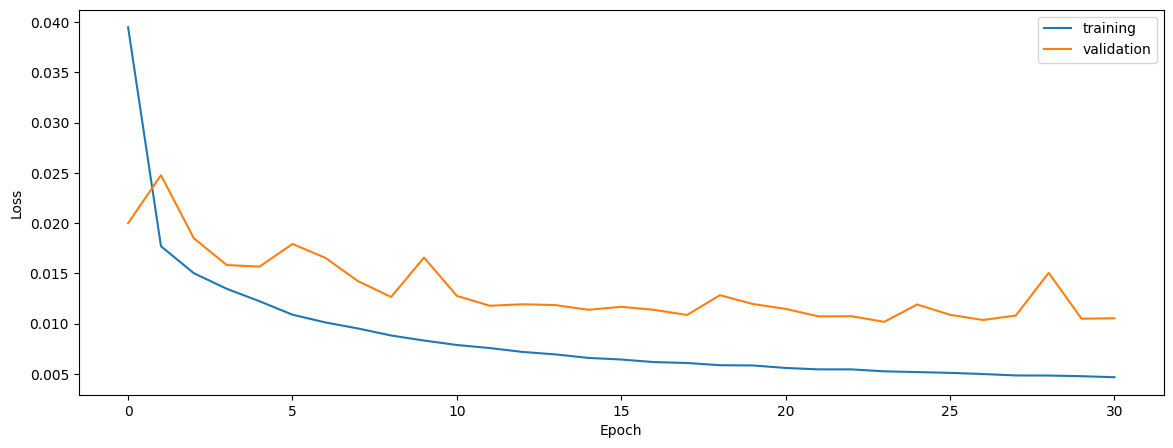

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9627403398428216
0.8379509658771594
0.8174325519896656


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.7678630835793013
0.7660285193223011
0.7691076816492944


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.7683912350204724
0.7713280395118652
0.7730868165821793


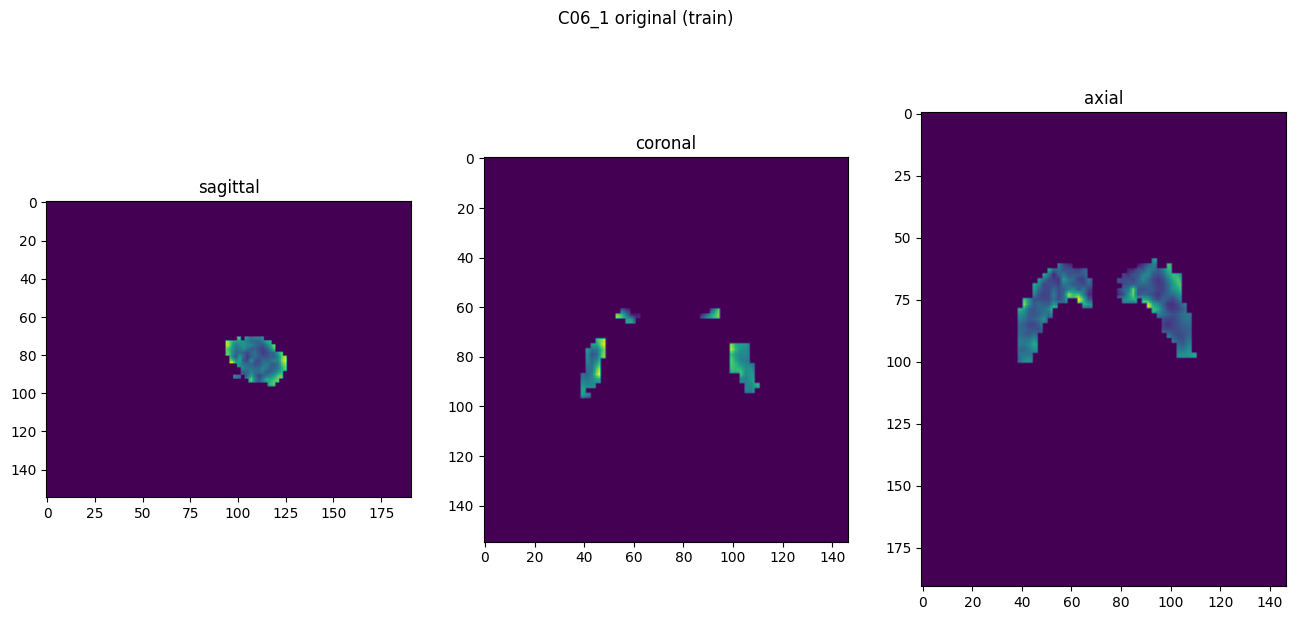

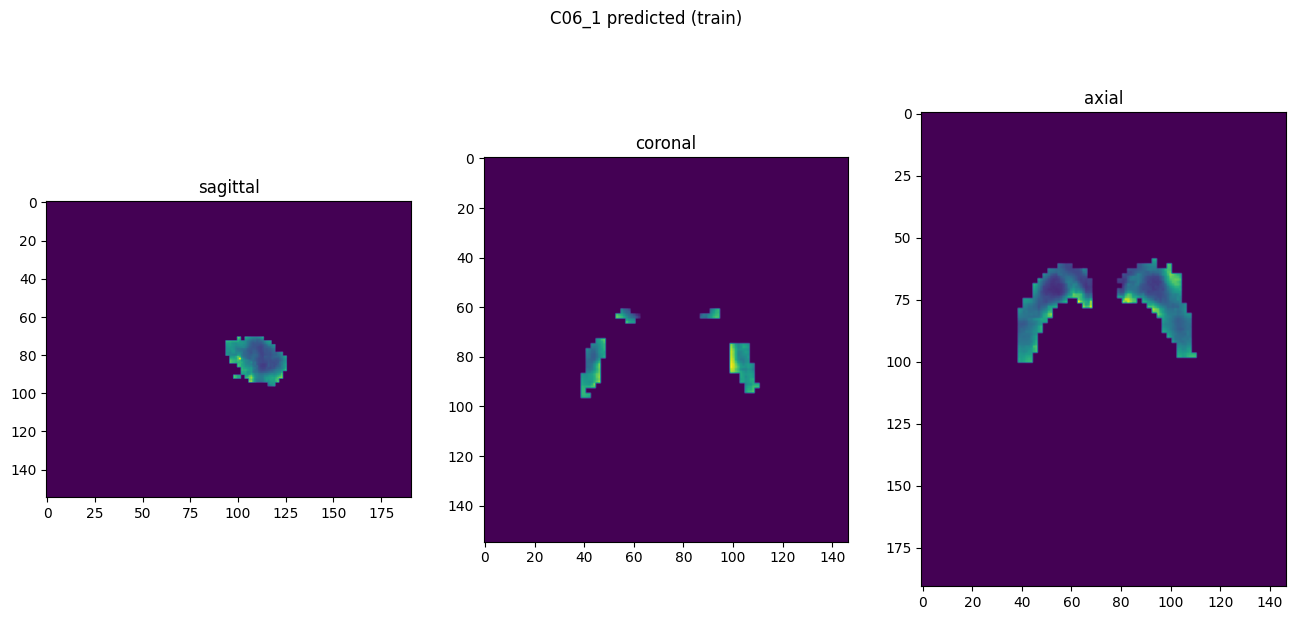

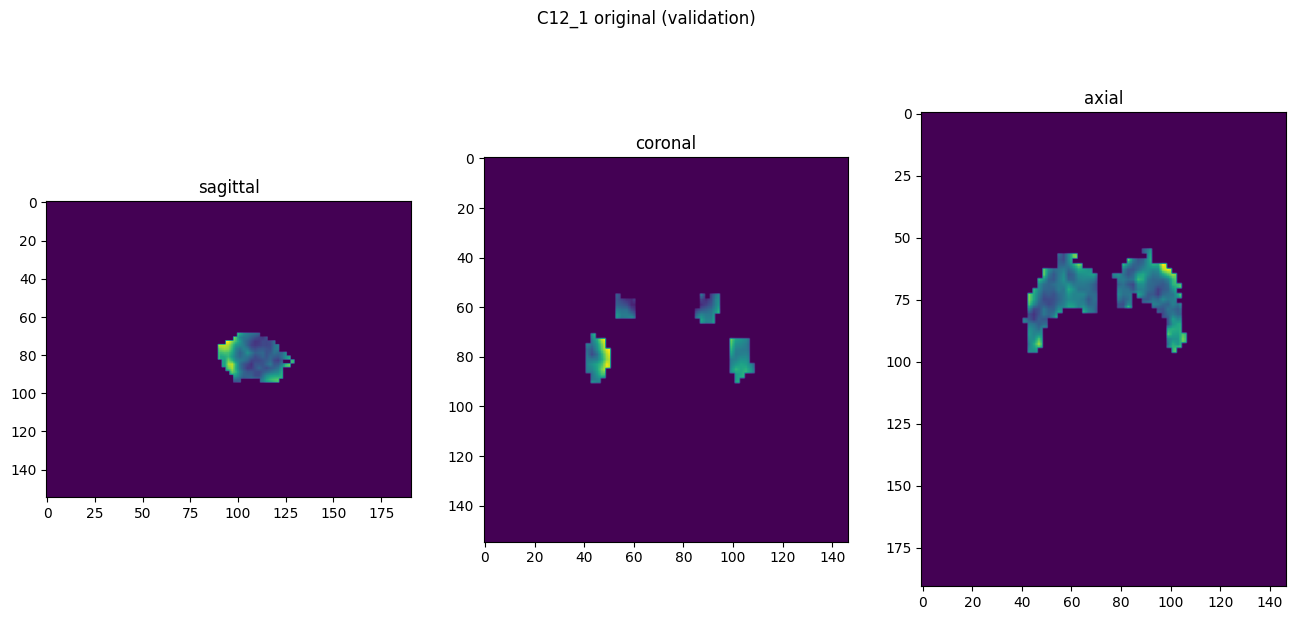

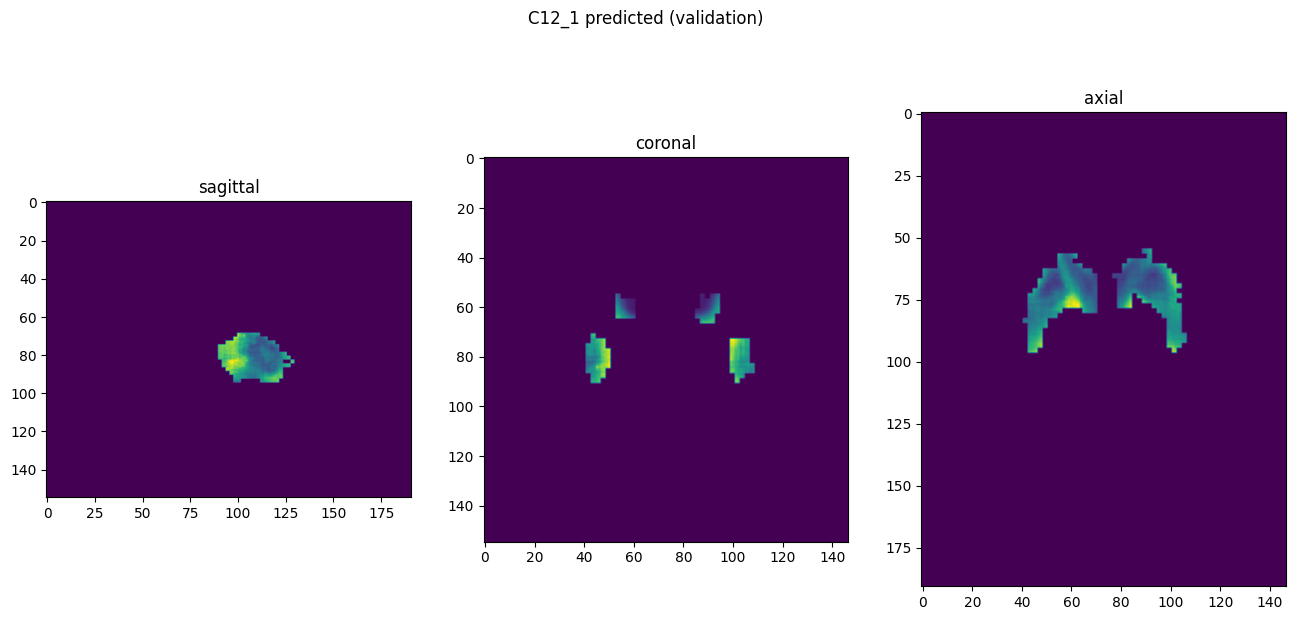

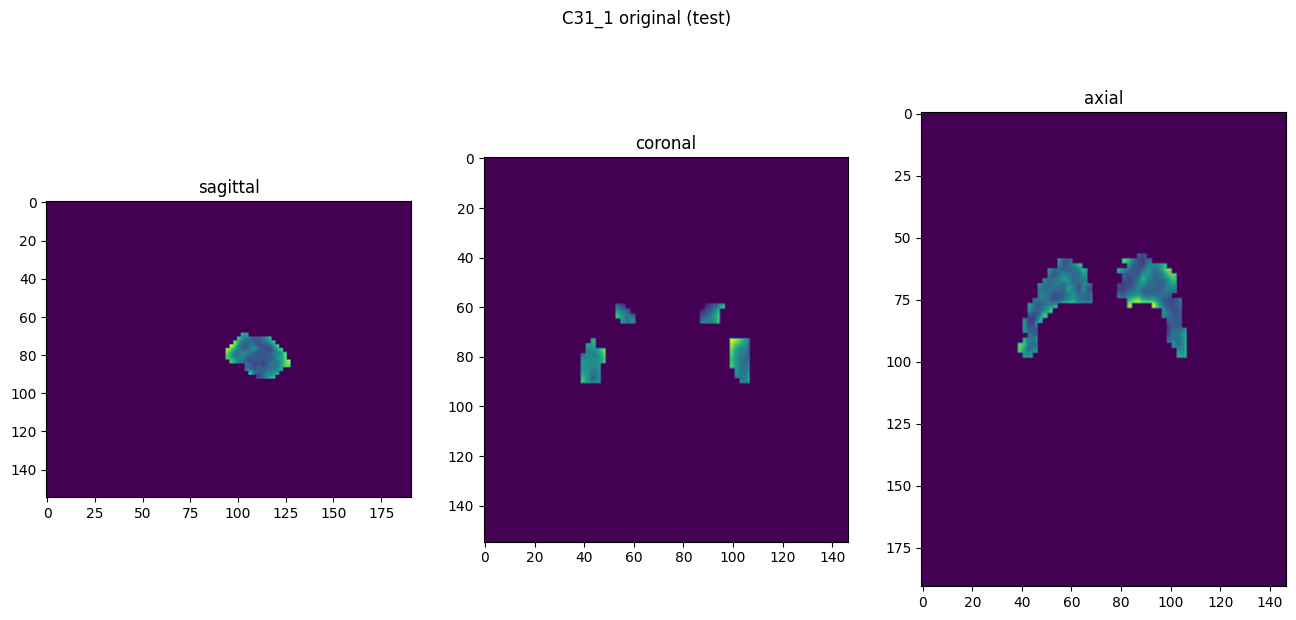

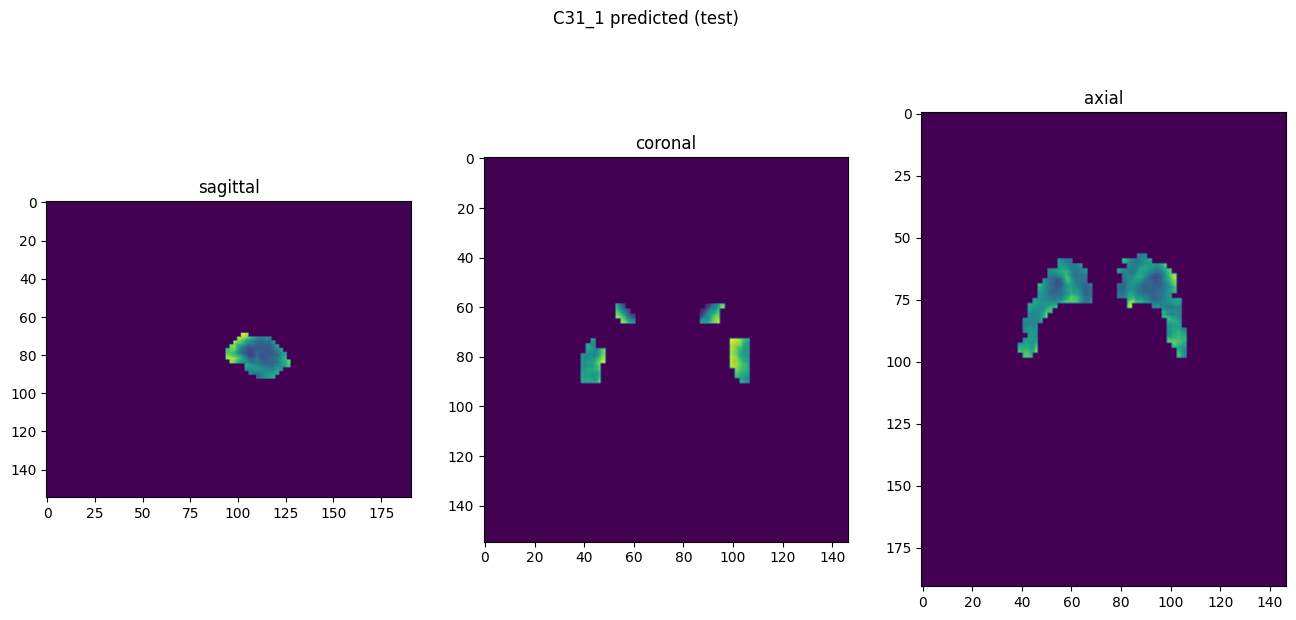

In [10]:
showResults(model, gen, threshold=None, background=False)